## Group Details
### Group No. 26
### Shah Harshil Hardik (23110132)
### Shah Tirth (23110295)

# Install the required packages

In [82]:
!pip install wandb -q
!pip install autogluon -q

# Section 1 - WandB

## Import the required libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback
import wandb

## Data preperation

In [70]:
np.random.seed(42)
tf.random.set_seed(42)

iris = load_iris()
X = iris.data
y = iris.target

encoder = OneHotEncoder(sparse=False)
y_one_hot = encoder.fit_transform(y.reshape(-1, 1))

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)  # 0.125 of 80% is 10% of the total

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## Define Model Architechture

In [45]:
def create_model():
    model = Sequential([
        Dense(16, activation='relu', input_shape=(4,), name='hidden_layer'),
        Dense(3, activation='softmax', name='output_layer')
    ])

    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

    return model

## Initialize WandB

In [ ]:
def init_wandb():
    wandb.init(
        project="iris-mlp-classification",
        config={
            "architecture": "MLP",
            "dataset": "Iris",
            "input_neurons": 4,
            "hidden_neurons": 16,
            "output_neurons": 3,
            "hidden_activation": "ReLU",
            "output_activation": "Softmax",
            "loss_function": "categorical_crossentropy",
            "optimizer": "Adam",
            "learning_rate": 0.001,
            "batch_size": 32,
            "epochs": 50
        }
    )
    return wandb

## Log Metrics in WandB

In [ ]:
class WandbMetricsLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        wandb.log({
            "train_loss": logs.get("loss"),
            "train_accuracy": logs.get("accuracy"),
            "val_loss": logs.get("val_loss"),
            "val_accuracy": logs.get("val_accuracy")
        })

wb = init_wandb()

model = create_model()

stringlist = []
model.summary(print_fn=lambda x: stringlist.append(x))
model_summary = "\n".join(stringlist)
wb.summary["model_summary"] = model_summary
plot_model(model, to_file="model_architecture.png", show_shapes=True, show_layer_names=True)
wandb.log({"model_architecture": wandb.Image("model_architecture.png")})

wandb_logger = WandbMetricsLogger()

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[wandb_logger],
    verbose=1
)

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
cm = confusion_matrix(y_true_classes, y_pred_classes)

wandb.log({
    "test_accuracy": accuracy,
    "test_precision": precision,
    "test_recall": recall,
    "test_f1_score": f1
})

## Plot Confusion Matrix

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=iris.target_names,
            yticklabels=iris.target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
wandb.log({"confusion_matrix": wandb.Image(plt)})
plt.savefig('confusion_matrix.png')

# Plot and log loss curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
wandb.log({"loss_curves": wandb.Image(plt)})
plt.savefig('loss_curves.png')

print("\nTest Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

wandb.finish()

# Section 2 - AutoGluon

#### `add_to_diagonal` function for AutoGluon was not working with latest `scikit-learn` version

In [3]:
!pip uninstall scikit-learn
!pip install scikit-learn==1.1.3

Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/scikit_learn-1.5.2.dist-info/*
    /usr/local/lib/python3.11/dist-packages/scikit_learn.libs/libgomp-a34b3233.so.1.0.0
    /usr/local/lib/python3.11/dist-packages/sklearn/*
Proceed (Y/n)? Y
  Successfully uninstalled scikit-learn-1.5.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.0/32.0 MB 15.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-core 1.2 requires scikit-learn<1.5.3,>=1.4.0, but you have scikit-learn 1.1.3 which is incompatible.
autogluon-multimodal 1.2 requires scikit-learn<1.5.3,>=1.4.0, but you have scikit-learn 1.1.3 which is incompatible.
autogluon-tabular 1.2 requires scikit-learn<1.5.3,>=1.4.0, but you have scikit-learn 1.1.3 which is incompatible.
autogluon-features 1.2 requ

### Import the required libraries.

In [86]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

import autogluon
from autogluon.core.models import AbstractModel
from autogluon.features.generators import LabelEncoderFeatureGenerator
from autogluon.common import space
from autogluon.tabular import TabularPredictor
import autogluon.core.searcher as ag_searcher
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

## Mannual Tuning

### Define Hyperparameters

In [54]:
epochs = [1, 3, 5]
lrs = [1e-3, 1e-5]
batch_sizes = [2, 4]

### Utility to plot the loss curves

In [79]:
def plot_losses(train_losses, val_losses, epoch, lr, batch_size):
    plt.figure(figsize=(8, 6))
    plt.scatter(range(1, epoch + 1), train_losses, label='Training Loss', color='blue')
    plt.scatter(range(1, epoch + 1), val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training vs Validation Loss - Epoch: {epoch}, LR: {lr}, Batch Size: {batch_size}')
    plt.legend()
    plt.show()

### Utility to plot the confusion matrix

In [75]:
def plot_cm(model):
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=iris.target_names,
                yticklabels=iris.target_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()


### Mannual search over all hyperparamters

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:666: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 2/[1, 3, 5] - Train Loss: 1.3746, Val Loss: 1.2291


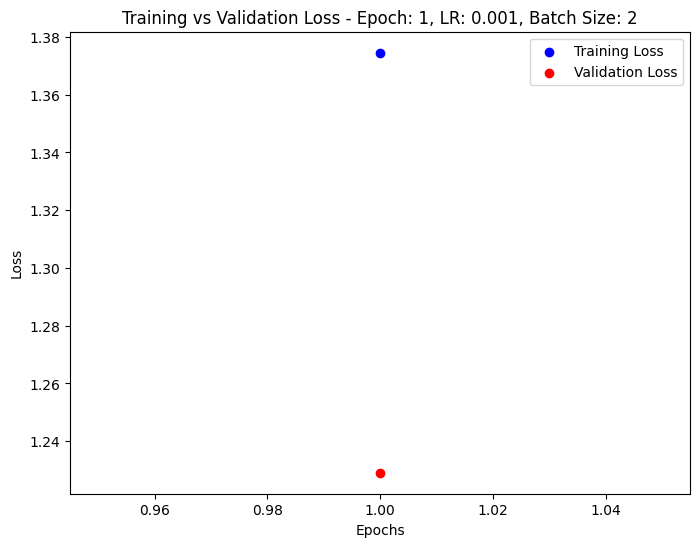

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


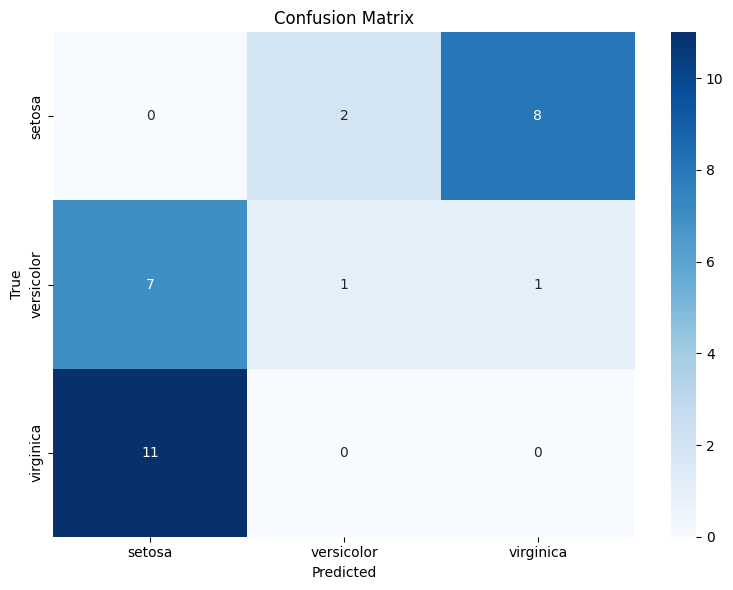

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:666: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 2/[1, 3, 5] - Train Loss: 0.7920, Val Loss: 0.8386


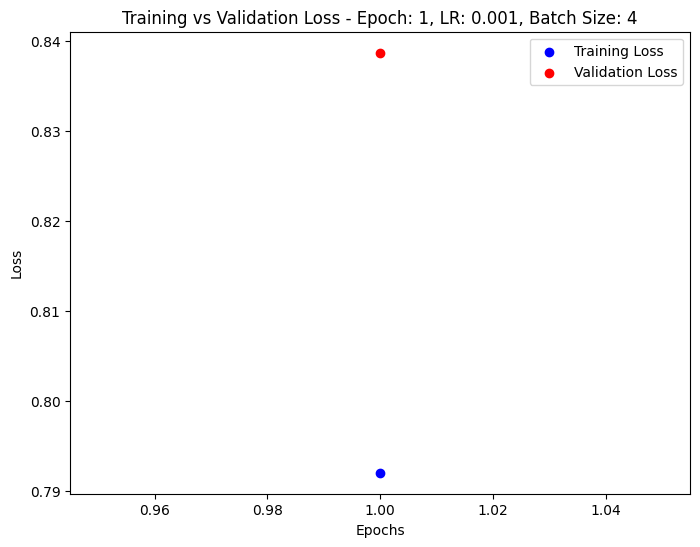

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


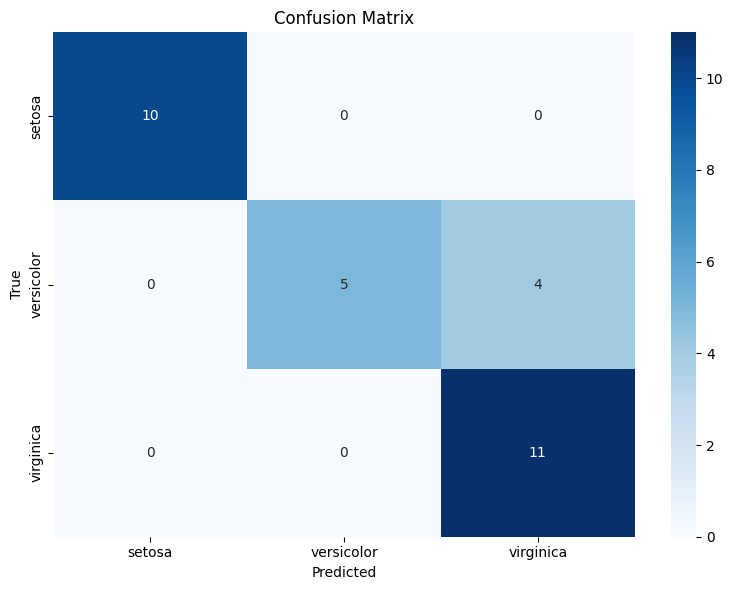

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:666: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 2/[1, 3, 5] - Train Loss: 1.0122, Val Loss: 1.0316


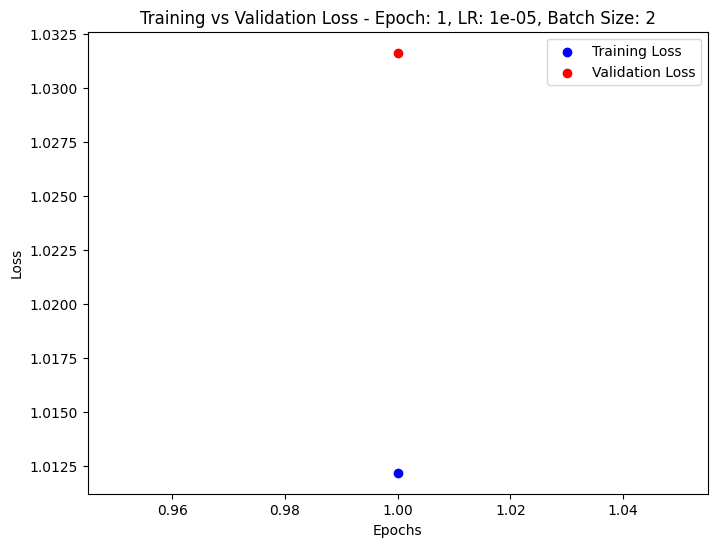

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


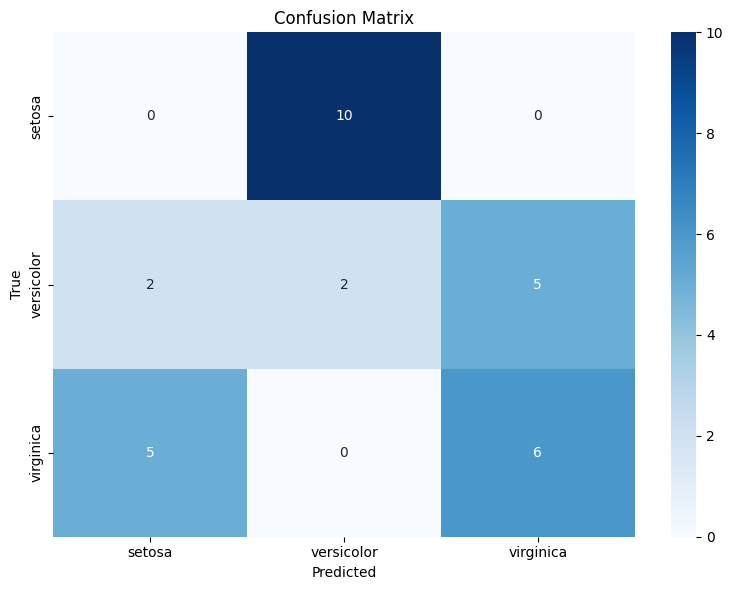

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:666: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 2/[1, 3, 5] - Train Loss: 0.9100, Val Loss: 0.9098


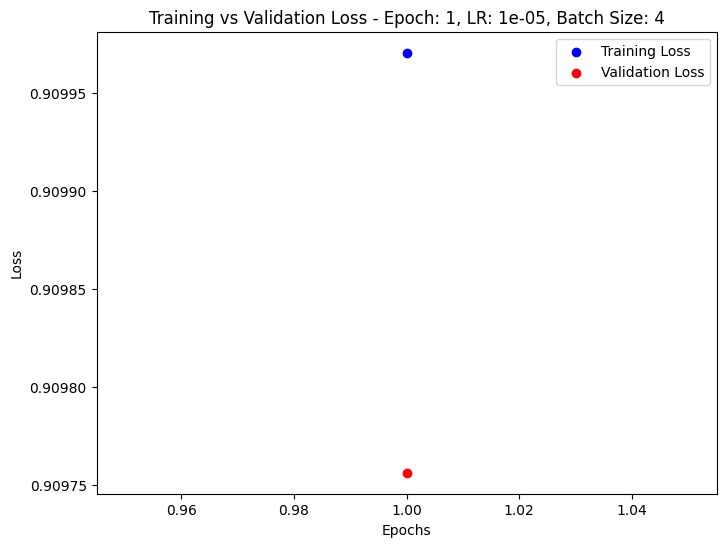

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


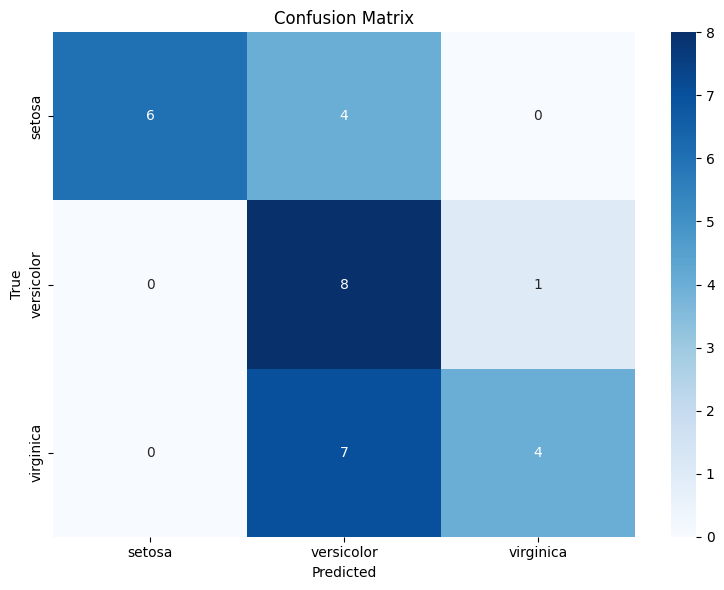

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:666: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 4/[1, 3, 5] - Train Loss: 1.5457, Val Loss: 1.1245
Epoch 4/[1, 3, 5] - Train Loss: 1.1899, Val Loss: 0.9201
Epoch 4/[1, 3, 5] - Train Loss: 0.9145, Val Loss: 0.7784


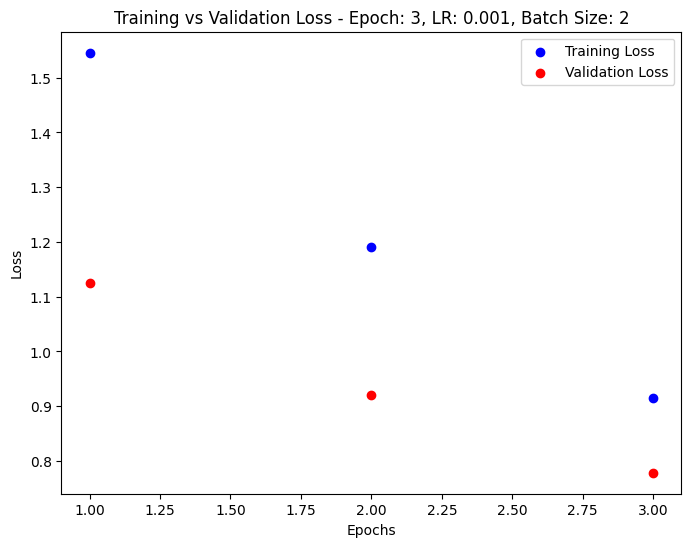

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


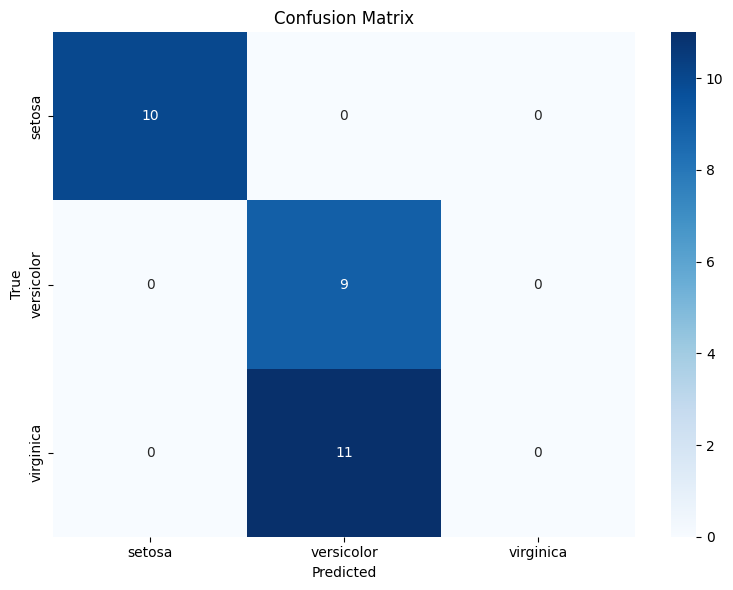

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:666: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 4/[1, 3, 5] - Train Loss: 1.1507, Val Loss: 1.2279
Epoch 4/[1, 3, 5] - Train Loss: 1.0283, Val Loss: 1.1320
Epoch 4/[1, 3, 5] - Train Loss: 0.9192, Val Loss: 1.0392


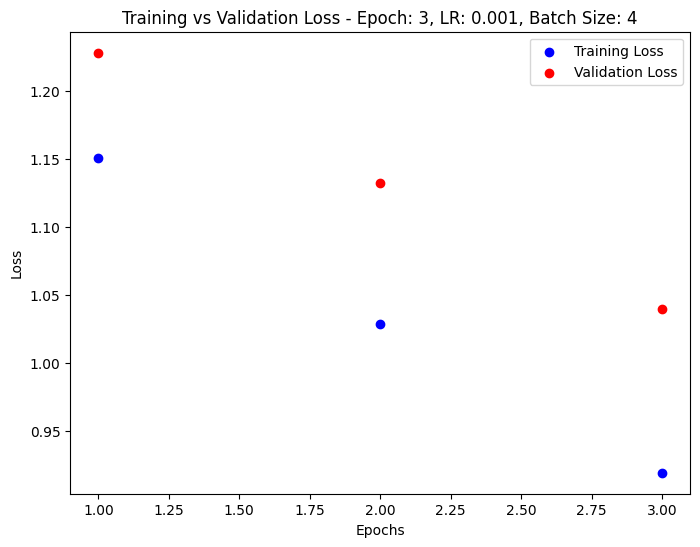

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


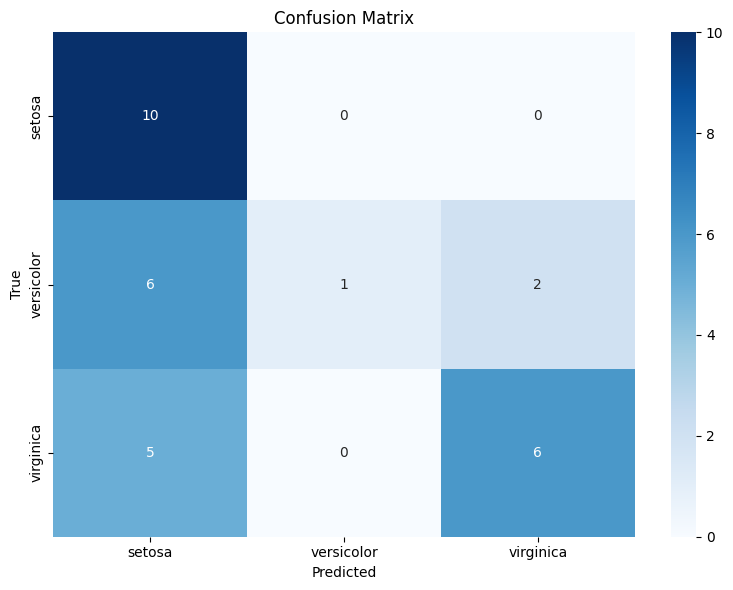

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:666: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 4/[1, 3, 5] - Train Loss: 1.0039, Val Loss: 1.0245
Epoch 4/[1, 3, 5] - Train Loss: 1.0017, Val Loss: 1.0231
Epoch 4/[1, 3, 5] - Train Loss: 0.9996, Val Loss: 1.0216


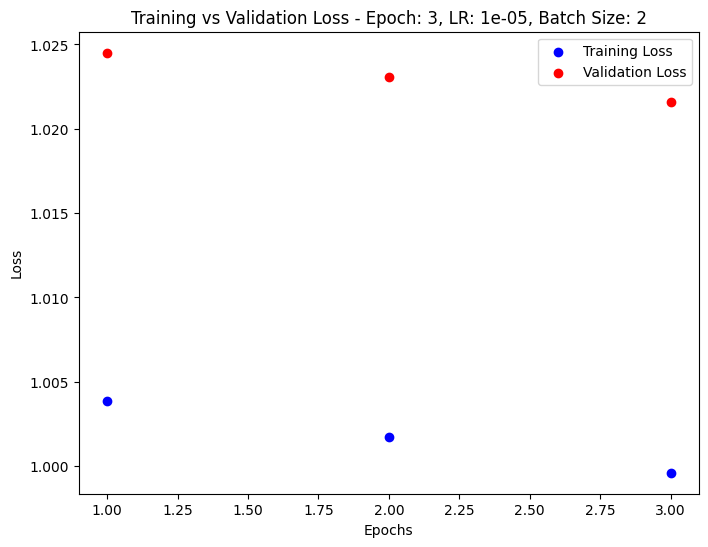

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


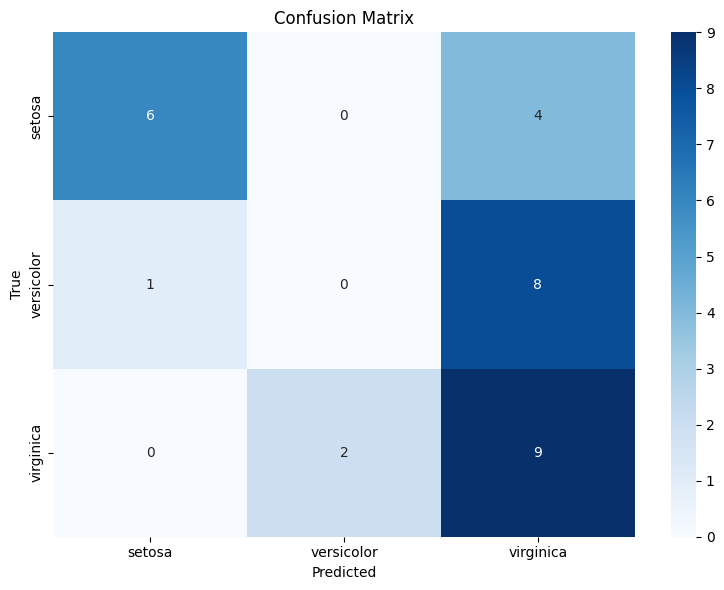

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:666: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 4/[1, 3, 5] - Train Loss: 1.3562, Val Loss: 1.4985
Epoch 4/[1, 3, 5] - Train Loss: 1.3544, Val Loss: 1.4969
Epoch 4/[1, 3, 5] - Train Loss: 1.3527, Val Loss: 1.4953


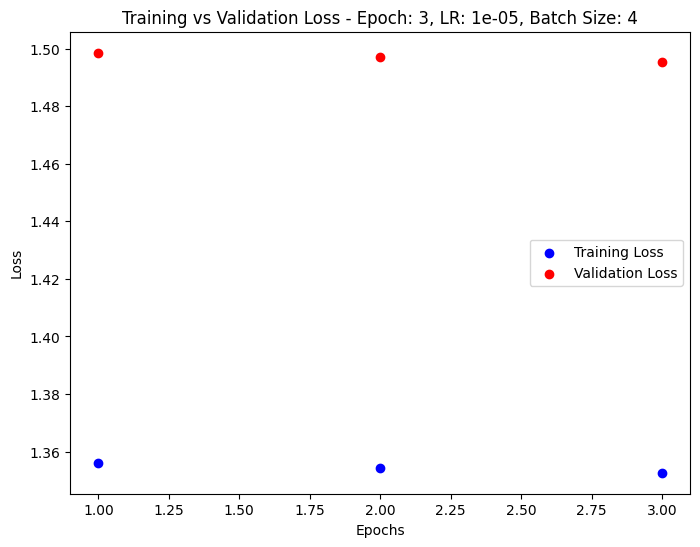

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


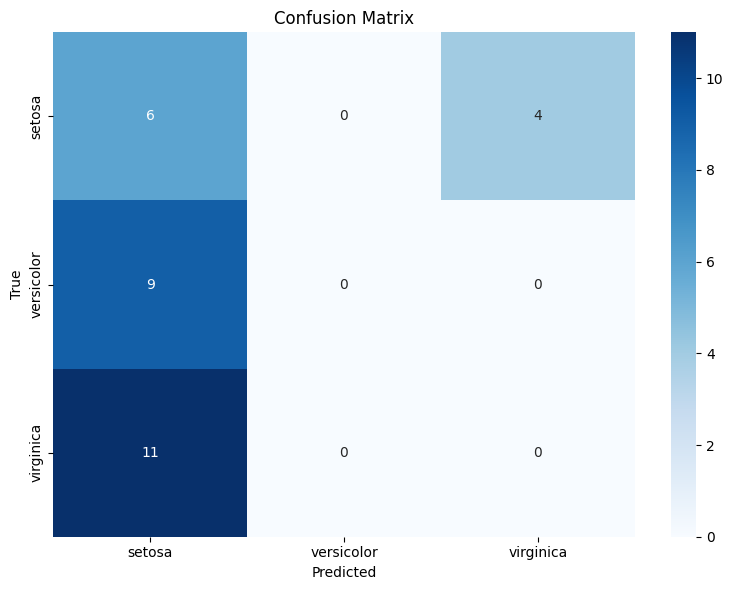

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:666: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 6/[1, 3, 5] - Train Loss: 1.3804, Val Loss: 1.3040
Epoch 6/[1, 3, 5] - Train Loss: 1.1021, Val Loss: 1.1031
Epoch 6/[1, 3, 5] - Train Loss: 0.8949, Val Loss: 0.9544
Epoch 6/[1, 3, 5] - Train Loss: 0.7324, Val Loss: 0.8381
Epoch 6/[1, 3, 5] - Train Loss: 0.6144, Val Loss: 0.7431


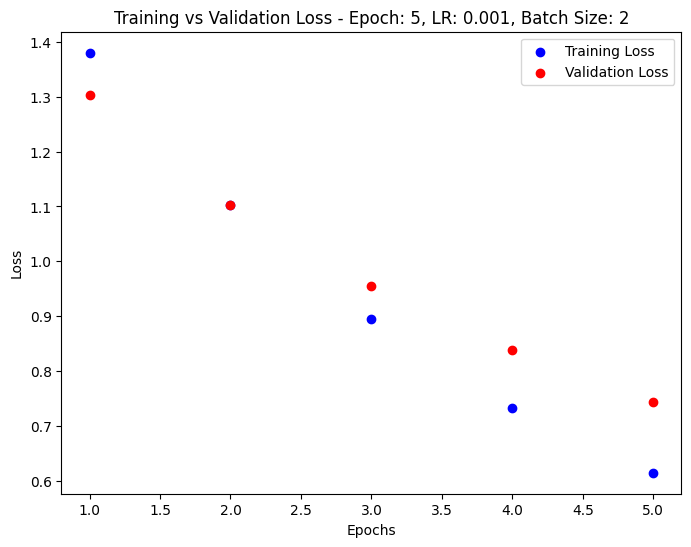

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


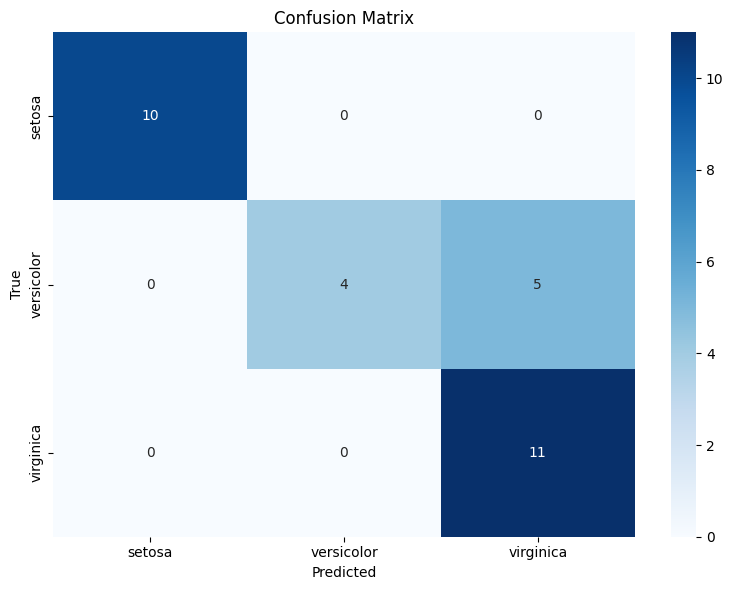

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:666: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 6/[1, 3, 5] - Train Loss: 0.8283, Val Loss: 0.8616
Epoch 6/[1, 3, 5] - Train Loss: 0.7332, Val Loss: 0.8020
Epoch 6/[1, 3, 5] - Train Loss: 0.6568, Val Loss: 0.7513
Epoch 6/[1, 3, 5] - Train Loss: 0.5965, Val Loss: 0.7057
Epoch 6/[1, 3, 5] - Train Loss: 0.5434, Val Loss: 0.6661


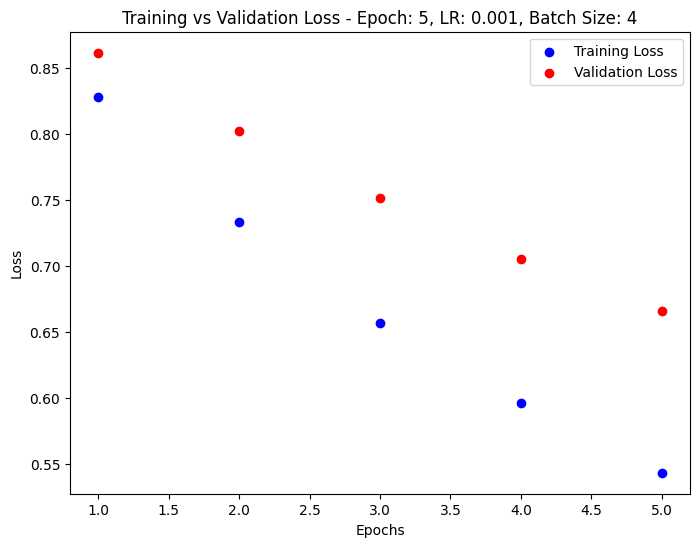

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


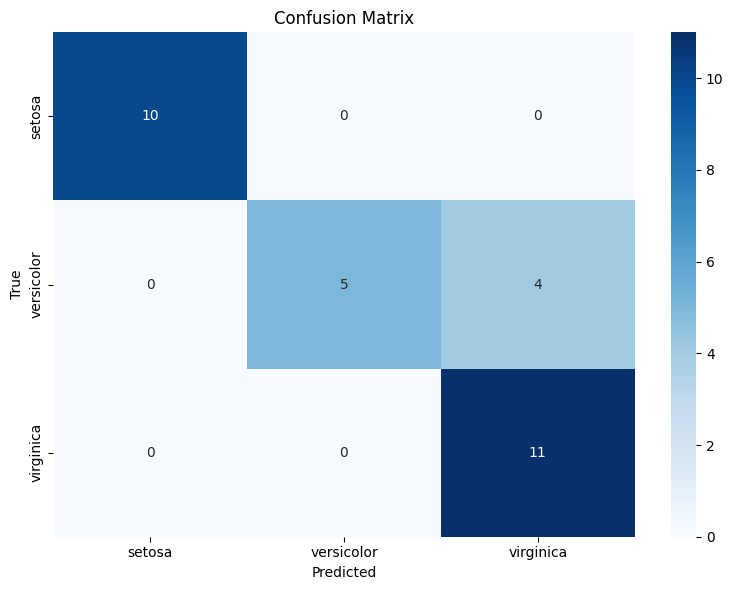

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:666: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 6/[1, 3, 5] - Train Loss: 1.0034, Val Loss: 0.9326
Epoch 6/[1, 3, 5] - Train Loss: 1.0010, Val Loss: 0.9314
Epoch 6/[1, 3, 5] - Train Loss: 0.9987, Val Loss: 0.9302
Epoch 6/[1, 3, 5] - Train Loss: 0.9964, Val Loss: 0.9290
Epoch 6/[1, 3, 5] - Train Loss: 0.9941, Val Loss: 0.9278


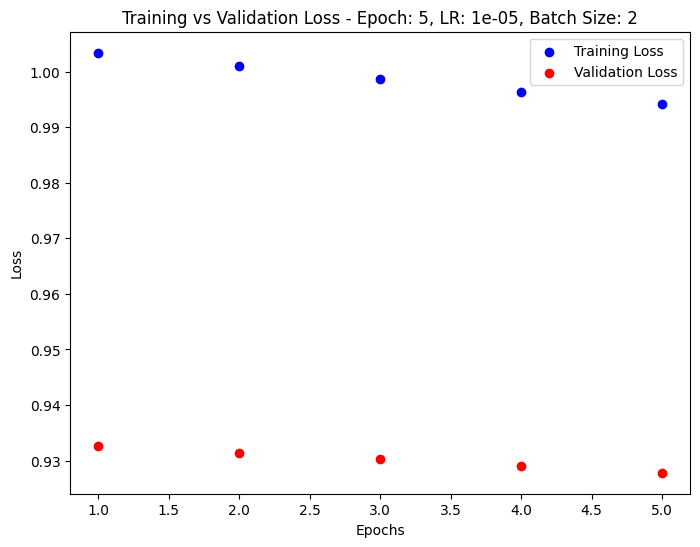

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


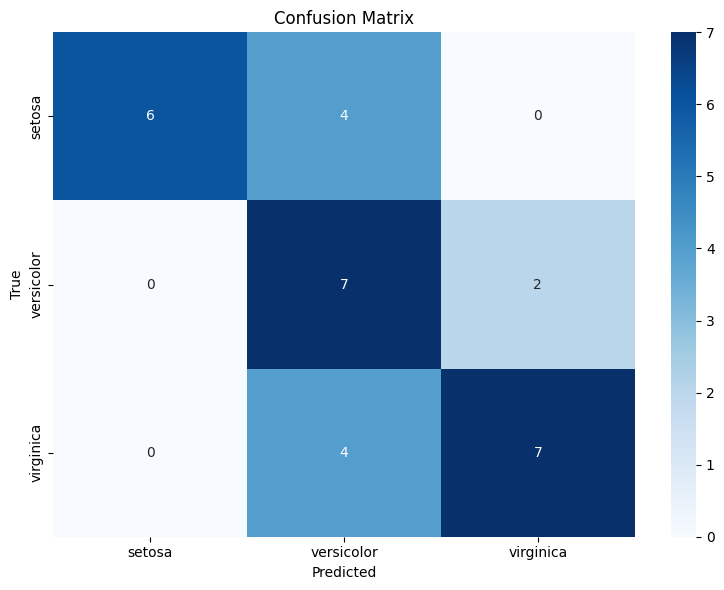

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:666: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 6/[1, 3, 5] - Train Loss: 1.2657, Val Loss: 1.1625
Epoch 6/[1, 3, 5] - Train Loss: 1.2634, Val Loss: 1.1612
Epoch 6/[1, 3, 5] - Train Loss: 1.2610, Val Loss: 1.1599
Epoch 6/[1, 3, 5] - Train Loss: 1.2587, Val Loss: 1.1585
Epoch 6/[1, 3, 5] - Train Loss: 1.2563, Val Loss: 1.1572


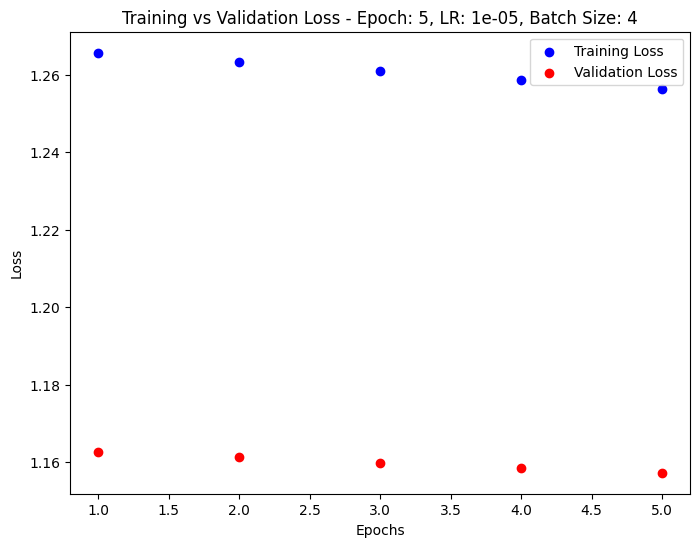

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


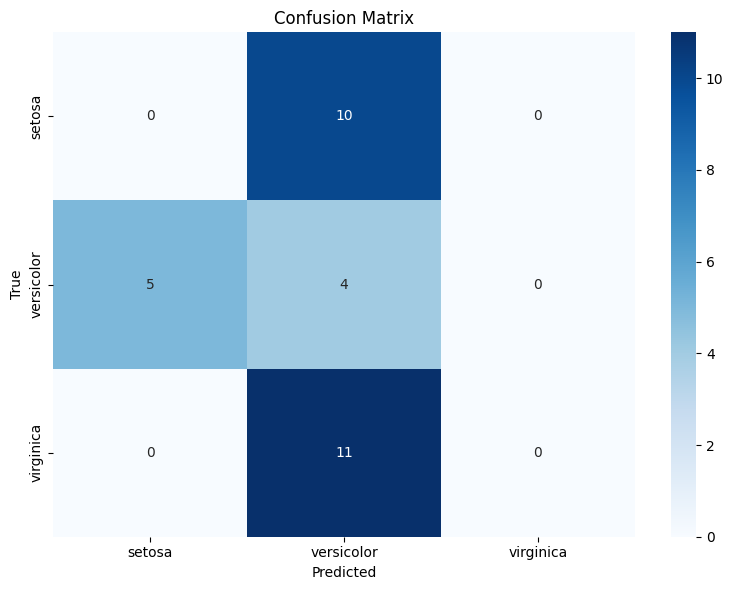

In [80]:
for epoch in epochs:
    for lr in lrs:
        for batch_size in batch_sizes:
            train_losses = []
            val_losses = []
            model = create_model()
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
            if hasattr(X_train, "toarray"):
                X_train = X_train.toarray()
            if hasattr(y_train, "toarray"):
                y_train = y_train.toarray()

            y_train = np.array(y_train).astype(np.int32)
            y_val = np.array(y_val).astype(np.int32)



            train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).shuffle(len(X_train))
            for e in range(epoch):
                running_loss = 0.0

                for batch_X, batch_y in train_dataset:
                    with tf.GradientTape() as tape:
                        logits = model(batch_X, training=True)
                        loss = tf.keras.losses.categorical_crossentropy(batch_y, logits, from_logits=False)
                        loss = tf.reduce_mean(loss)
                    gradients = tape.gradient(loss, model.trainable_variables)
                    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                    running_loss += loss.numpy()

                avg_train_loss = running_loss / len(train_dataset)
                train_losses.append(avg_train_loss)

                val_outputs = model(X_val, training=False)
                val_loss = tf.keras.losses.categorical_crossentropy(y_val, val_outputs, from_logits=True)
                val_loss = tf.reduce_mean(val_loss).numpy()
                val_losses.append(val_loss)

                print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")

            plot_losses(train_losses, val_losses, epoch, lr, batch_size)
            plot_cm(model)

## Automated Search

### Creating a Custom Class to use the custom model with AutoGluon
source = [AutoGluon Dcoumentation](https://auto.gluon.ai/0.3.1/tutorials/tabular_prediction/tabular-custom-model.html)

In [141]:
class CustomNeuralNetworkClassifier(AbstractModel):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self._feature_generator = None
        self.model = None
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set device

    def _preprocess(self, X: pd.DataFrame, is_train=False, **kwargs) -> np.ndarray:
        X = super()._preprocess(X, **kwargs)
        if is_train:
            self._feature_generator = LabelEncoderFeatureGenerator(verbosity=0)   # Encodes the labels to encoder format supported by AutoGluon
            self._feature_generator.fit(X=X)
        if self._feature_generator is not None and self._feature_generator.features_in:
            X = X.copy()
            X[self._feature_generator.features_in] = self._feature_generator.transform(X=X)
        return X.fillna(0).to_numpy(dtype=np.float32)

    def _fit(self, X: pd.DataFrame, y: pd.Series, **kwargs):
        X = self.preprocess(X, is_train=True)
        params = self._get_model_params()
        print(f"Hyperparameters: {params}")

        # Split data into train and validation sets
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.13, random_state=42)   # Same splitting as done in task 1

        self.model = create_model()       # Get model
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params.get('learning_rate', 0.001)),
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

        X_train_tensor = np.array(X_train, dtype=np.float32)
        y_train_tensor = np.array(y_train.to_numpy(), dtype=np.int32)
        X_val_tensor = np.array(X_val, dtype=np.float32)
        y_val_tensor = np.array(y_val.to_numpy(), dtype=np.int32)

        epochs = params.get('epochs', 10)
        batch_size = params.get('batch_size', 32)

        train_dataset = tf.data.Dataset.from_tensor_slices((X_train_tensor, y_train_tensor)).batch(batch_size).shuffle(len(X_train_tensor))

        train_losses = []
        val_losses = []

        for epoch in range(epochs):
            running_loss = 0.0

            for batch_X, batch_y in train_dataset:
                with tf.GradientTape() as tape:
                    logits = self.model(batch_X, training=True)
                    loss = tf.keras.losses.sparse_categorical_crossentropy(batch_y, logits, from_logits=True)
                    loss = tf.reduce_mean(loss)
                gradients = tape.gradient(loss, self.model.trainable_variables)
                self.model.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
                running_loss += loss.numpy()

            avg_train_loss = running_loss / len(train_dataset)
            train_losses.append(avg_train_loss)

            val_outputs = self.model(X_val_tensor, training=False)
            val_loss = tf.keras.losses.sparse_categorical_crossentropy(y_val_tensor, val_outputs, from_logits=True)
            val_loss = tf.reduce_mean(val_loss).numpy()
            val_losses.append(val_loss)

            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Plot training vs validation loss
        plt.figure(figsize=(8, 6))
        plt.scatter(range(1, epochs + 1), train_losses, label='Training Loss', color='blue')
        plt.scatter(range(1, epochs + 1), val_losses, label='Validation Loss', color='red')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Training vs Validation Loss lr = {params.get("learning_rate", 0.001)}, batch_size = {batch_size}, epochs = {epochs}')
        plt.legend()
        plt.show()


    def _predict(self, X: pd.DataFrame, **kwargs):
        X = self.preprocess(X, is_train=False)
        X_array = np.array(X, dtype=np.float32)

        logits = self.model(X_array, training=False)
        predictions = np.argmax(logits, axis=1)

        return predictions


    def _predict_proba(self, X: pd.DataFrame, **kwargs):
        X = self.preprocess(X, is_train=False)
        X_array = np.array(X, dtype=np.float32)

        logits = self.model(X_array, training=False)
        probs = tf.nn.softmax(logits).numpy()  # Apply softmax to get probabilities

        return probs


    def _set_default_params(self):
        default_params = {
            'learning_rate': 0.001,
            'epochs': 10,
            'batch_size': 32
        }
        for param, val in default_params.items():
            self._set_default_param_value(param, val)

    def _get_default_auxiliary_params(self) -> dict:
        default_auxiliary_params = super()._get_default_auxiliary_params()
        extra_auxiliary_params = {'valid_raw_types': ['int', 'float', 'category']}
        default_auxiliary_params.update(extra_auxiliary_params)
        return default_auxiliary_params

### Define the hyperparameter search space

In [142]:
custom_hyperparameters = {
    CustomNeuralNetworkClassifier: {
        'batch_size': space.Categorical(2, 4),
        'learning_rate': space.Categorical(1e-3, 1e-5),
        'epochs': space.Categorical(1, 3, 5)
    }
}

### Convert data to `pandas` dataframe
(as autogluon supports only dataframe as training data)

In [143]:
y_train_df = pd.DataFrame(np.ravel(y_train.argmax(axis=1)))
X_train_df = pd.DataFrame(X_train)
train_df = X_train_df.copy()
train_df['target'] = y_train_df

X_test_df = pd.DataFrame(X_test)
y_test_df = pd.DataFrame(np.ravel(y_test.argmax(axis=1)))
test_df = X_test_df.copy()
test_df['target'] = y_test_df

### Grid Search

AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Hyperparameters: {'learning_rate': 0.001, 'epochs': 1, 'batch_size': 2}
Epoch 1/1 - Train Loss: 1.0310, Val Loss: 0.9684


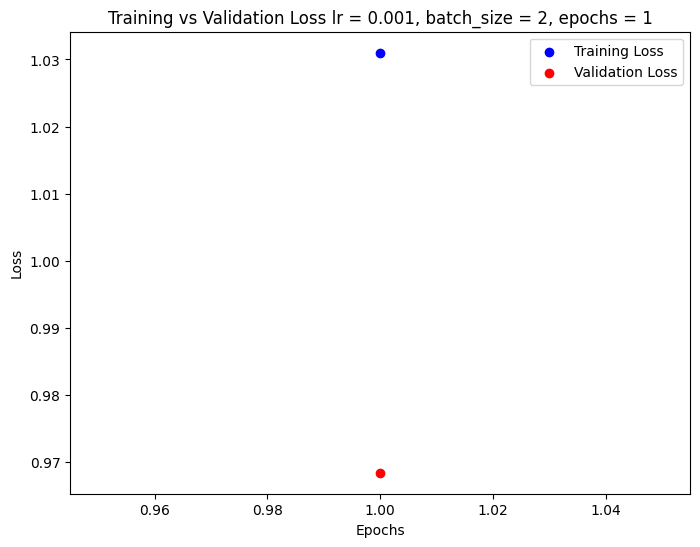

Hyperparameters: {'learning_rate': 1e-05, 'epochs': 1, 'batch_size': 2}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/1 - Train Loss: 1.2503, Val Loss: 1.2223


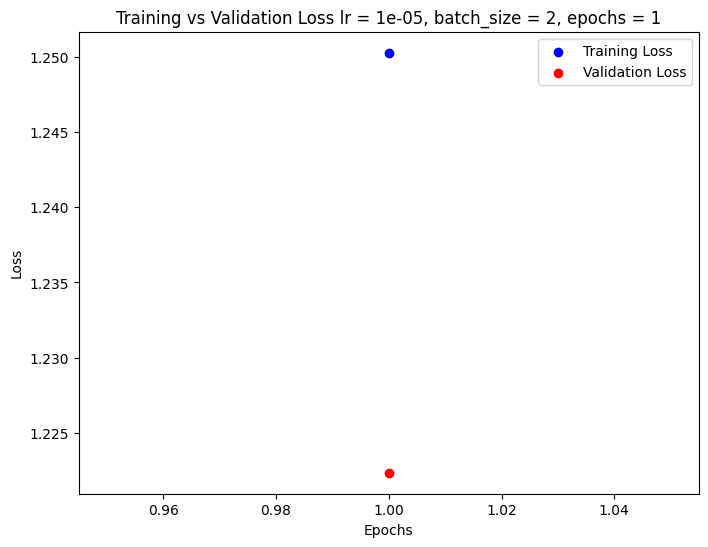

Hyperparameters: {'learning_rate': 0.001, 'epochs': 3, 'batch_size': 2}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/3 - Train Loss: 1.2272, Val Loss: 1.1921
Epoch 2/3 - Train Loss: 1.0433, Val Loss: 0.9694
Epoch 3/3 - Train Loss: 0.9105, Val Loss: 0.8042


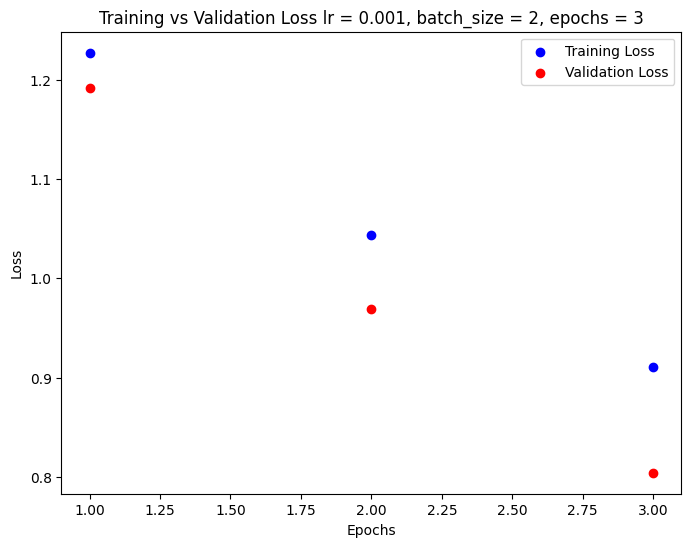

Hyperparameters: {'learning_rate': 1e-05, 'epochs': 3, 'batch_size': 2}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/3 - Train Loss: 1.0888, Val Loss: 1.1801
Epoch 2/3 - Train Loss: 1.0872, Val Loss: 1.1775
Epoch 3/3 - Train Loss: 1.0855, Val Loss: 1.1750


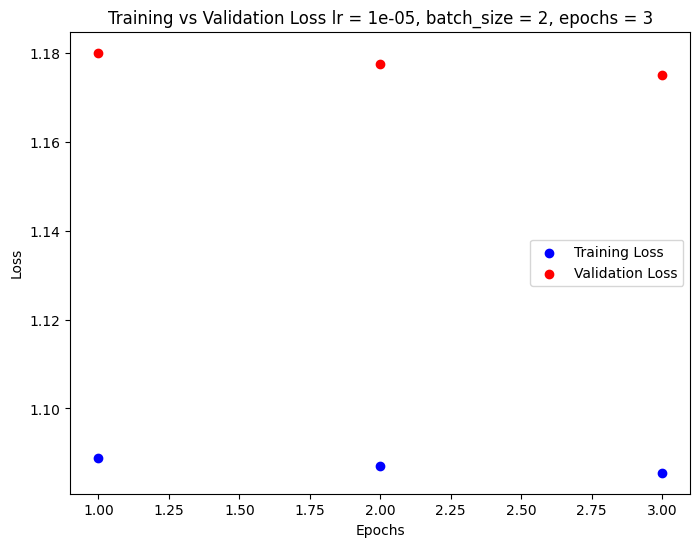

Hyperparameters: {'learning_rate': 0.001, 'epochs': 5, 'batch_size': 2}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/5 - Train Loss: 1.1602, Val Loss: 1.1529
Epoch 2/5 - Train Loss: 0.9384, Val Loss: 0.8376
Epoch 3/5 - Train Loss: 0.7710, Val Loss: 0.6258
Epoch 4/5 - Train Loss: 0.6534, Val Loss: 0.4982
Epoch 5/5 - Train Loss: 0.5705, Val Loss: 0.4173


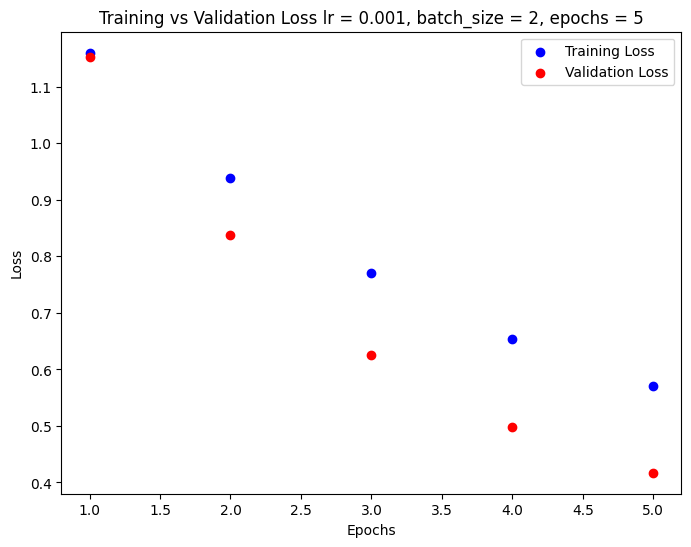

Hyperparameters: {'learning_rate': 1e-05, 'epochs': 5, 'batch_size': 2}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/5 - Train Loss: 1.1169, Val Loss: 1.2339
Epoch 2/5 - Train Loss: 1.1146, Val Loss: 1.2298
Epoch 3/5 - Train Loss: 1.1121, Val Loss: 1.2262
Epoch 4/5 - Train Loss: 1.1097, Val Loss: 1.2222
Epoch 5/5 - Train Loss: 1.1074, Val Loss: 1.2181


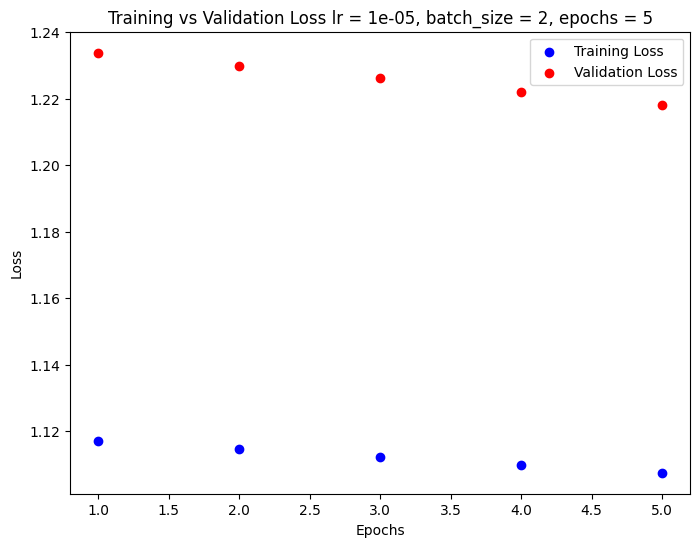

Hyperparameters: {'learning_rate': 0.001, 'epochs': 1, 'batch_size': 4}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/1 - Train Loss: 1.0835, Val Loss: 1.0024


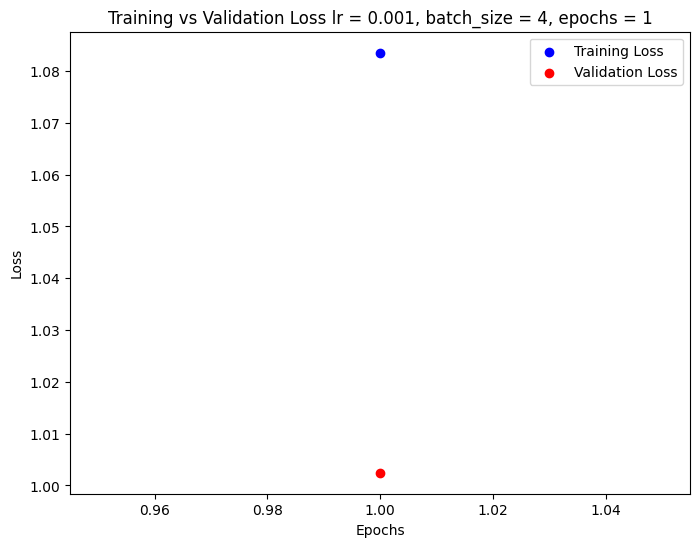

Hyperparameters: {'learning_rate': 1e-05, 'epochs': 1, 'batch_size': 4}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/1 - Train Loss: 1.5937, Val Loss: 1.9655


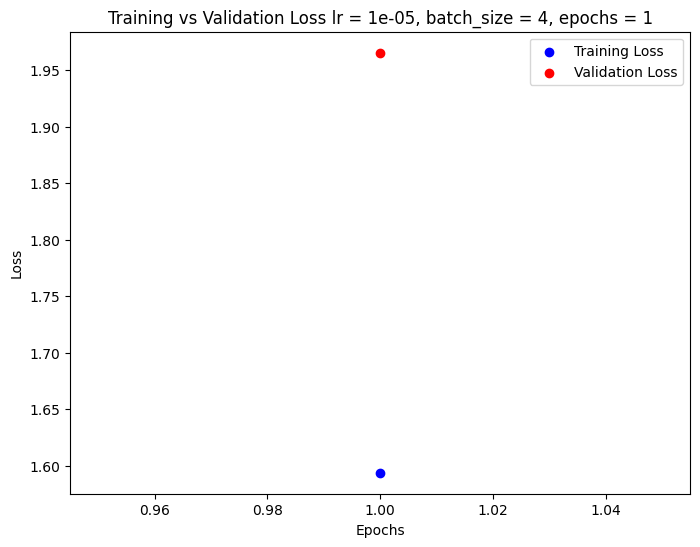

Hyperparameters: {'learning_rate': 0.001, 'epochs': 3, 'batch_size': 4}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/3 - Train Loss: 1.0635, Val Loss: 0.8891
Epoch 2/3 - Train Loss: 0.9431, Val Loss: 0.7470
Epoch 3/3 - Train Loss: 0.8434, Val Loss: 0.6411


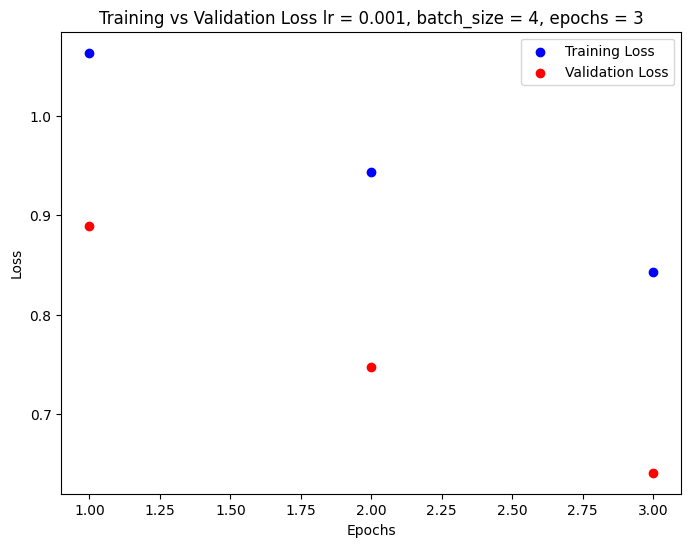

Hyperparameters: {'learning_rate': 1e-05, 'epochs': 3, 'batch_size': 4}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/3 - Train Loss: 1.5221, Val Loss: 1.5030
Epoch 2/3 - Train Loss: 1.5201, Val Loss: 1.5008
Epoch 3/3 - Train Loss: 1.5183, Val Loss: 1.4985


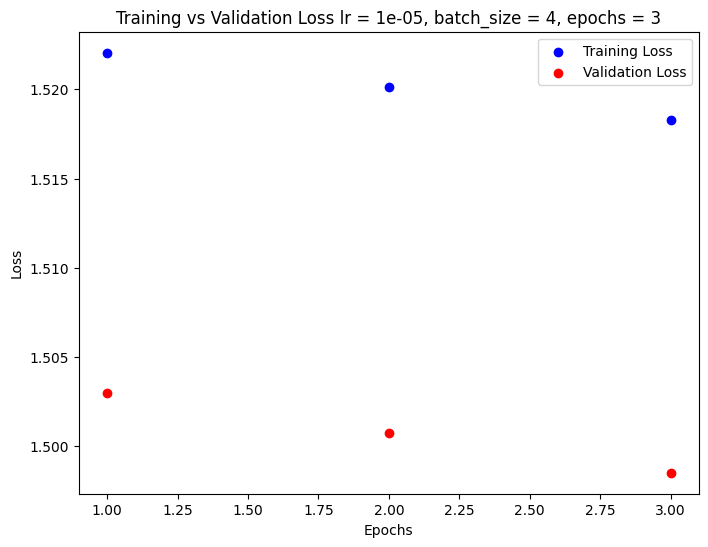

Hyperparameters: {'learning_rate': 0.001, 'epochs': 5, 'batch_size': 4}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/5 - Train Loss: 1.2958, Val Loss: 1.2871
Epoch 2/5 - Train Loss: 1.1716, Val Loss: 1.1156
Epoch 3/5 - Train Loss: 1.0614, Val Loss: 0.9697
Epoch 4/5 - Train Loss: 0.9667, Val Loss: 0.8395
Epoch 5/5 - Train Loss: 0.8803, Val Loss: 0.7327


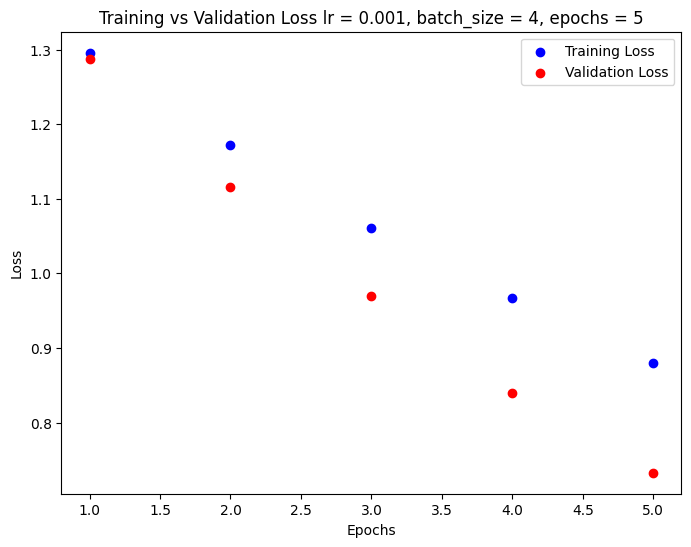

Hyperparameters: {'learning_rate': 1e-05, 'epochs': 5, 'batch_size': 4}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/5 - Train Loss: 1.3193, Val Loss: 1.4438
Epoch 2/5 - Train Loss: 1.3181, Val Loss: 1.4421
Epoch 3/5 - Train Loss: 1.3168, Val Loss: 1.4403
Epoch 4/5 - Train Loss: 1.3156, Val Loss: 1.4387
Epoch 5/5 - Train Loss: 1.3144, Val Loss: 1.4369


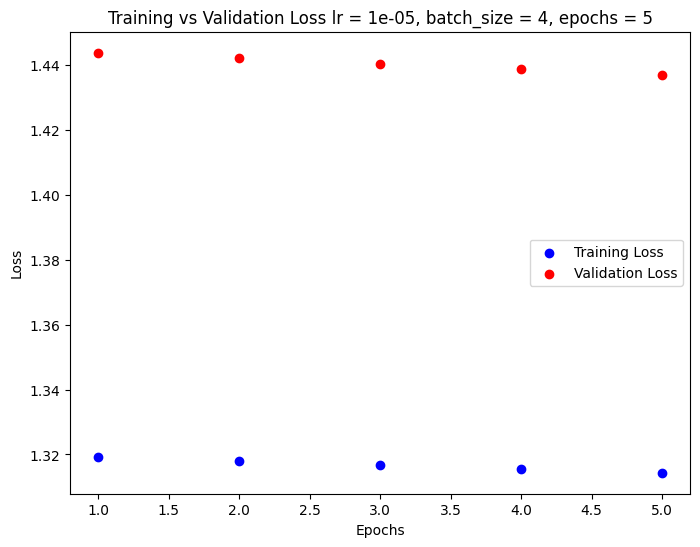

Detailed Traceback:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/autogluon/core/scheduler/seq_scheduler.py", line 158, in run
    is_failed, result = self.run_trial(task_id=i)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/autogluon/core/scheduler/seq_scheduler.py", line 254, in run_trial
    new_searcher_config = self.searcher.get_config()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/autogluon/core/searcher/local_grid_searcher.py", line 70, in get_config
    raise AssertionError(f"No configs left to get. All {self._grid_length} configs have been accessed already.")
AssertionError: No configs left to get. All 12 configs have been accessed already.


In [144]:
grid_searcher_instance = ag_searcher.LocalGridSearcher(search_space=custom_hyperparameters[CustomNeuralNetworkClassifier])

grid_search_tune_kwargs = {
    "scheduler": "local",
    "searcher": grid_searcher_instance,
    "time_out": 200000
}

grid_predictor = TabularPredictor(label='target', path='my_models/grid_search', eval_metric='accuracy').fit(
    train_df,
    hyperparameters=custom_hyperparameters,
    hyperparameter_tune_kwargs=grid_search_tune_kwargs,
    time_limit=200,
    raise_on_no_models_fitted=False,
    verbosity=1
)

### Random Search

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       9.18 GB / 12.67 GB (72.4%)
Disk Space Avail:   73.39 GB / 107.72 GB (68.1%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'         : Strong accuracy with fast inference spee

Hyperparameters: {'learning_rate': 0.001, 'epochs': 1, 'batch_size': 2}
Epoch 1/1 - Train Loss: 0.8702, Val Loss: 0.8118


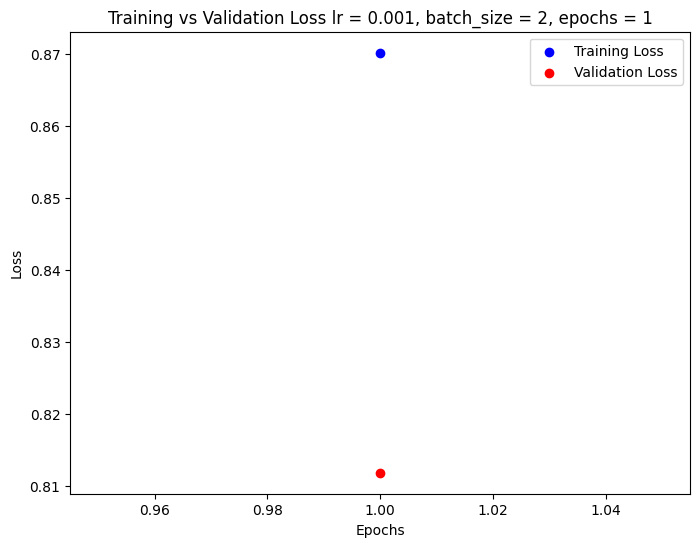

Hyperparameters: {'learning_rate': 0.001, 'epochs': 1, 'batch_size': 4}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/1 - Train Loss: 1.2638, Val Loss: 1.3780


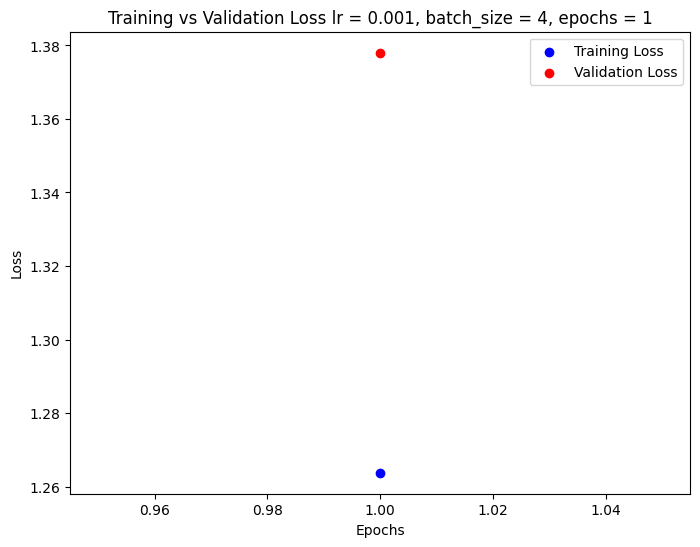

Hyperparameters: {'learning_rate': 1e-05, 'epochs': 5, 'batch_size': 2}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/5 - Train Loss: 1.2625, Val Loss: 1.3188
Epoch 2/5 - Train Loss: 1.2602, Val Loss: 1.3160
Epoch 3/5 - Train Loss: 1.2581, Val Loss: 1.3129
Epoch 4/5 - Train Loss: 1.2559, Val Loss: 1.3101
Epoch 5/5 - Train Loss: 1.2537, Val Loss: 1.3069


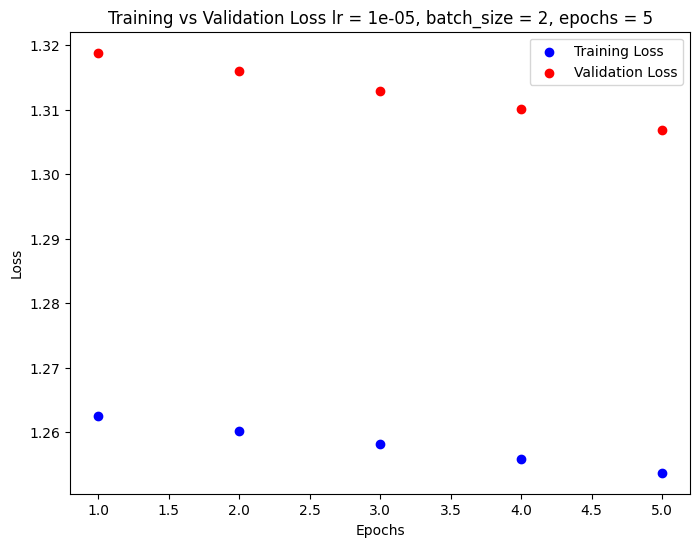

Hyperparameters: {'learning_rate': 0.001, 'epochs': 3, 'batch_size': 2}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/3 - Train Loss: 1.0832, Val Loss: 1.0710
Epoch 2/3 - Train Loss: 0.9165, Val Loss: 0.8416
Epoch 3/3 - Train Loss: 0.7855, Val Loss: 0.6662


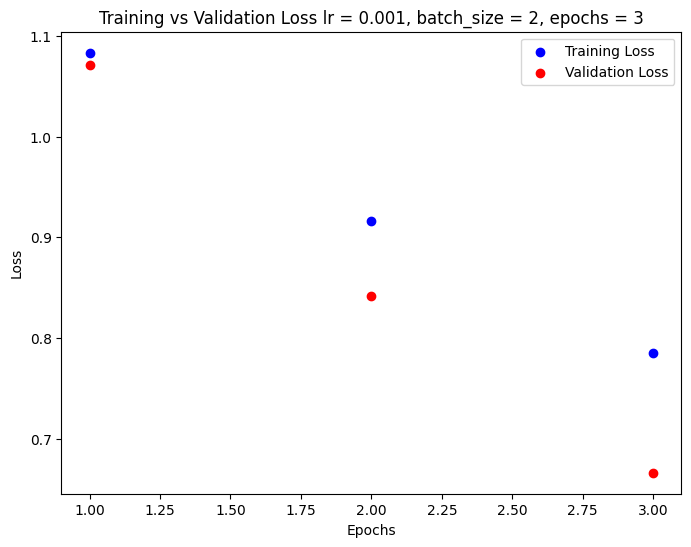

Hyperparameters: {'learning_rate': 1e-05, 'epochs': 1, 'batch_size': 2}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/1 - Train Loss: 1.0913, Val Loss: 1.0320


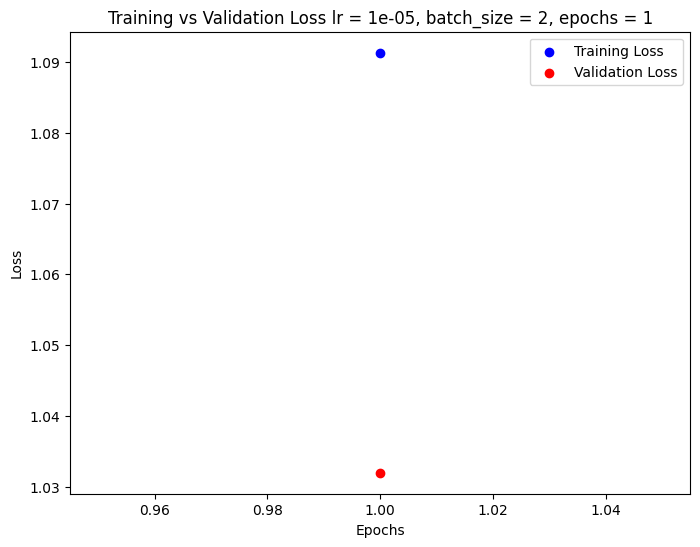

Hyperparameters: {'learning_rate': 1e-05, 'epochs': 3, 'batch_size': 2}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/3 - Train Loss: 1.7738, Val Loss: 2.2152
Epoch 2/3 - Train Loss: 1.7709, Val Loss: 2.2110
Epoch 3/3 - Train Loss: 1.7680, Val Loss: 2.2064


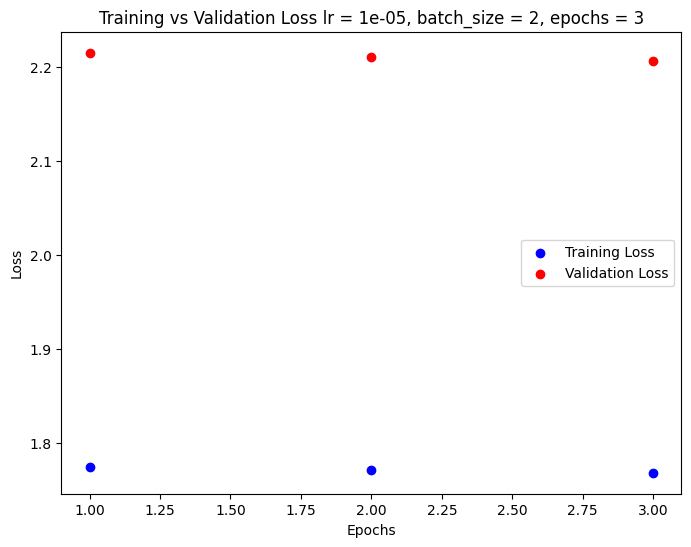

Hyperparameters: {'learning_rate': 1e-05, 'epochs': 3, 'batch_size': 4}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/3 - Train Loss: 0.7812, Val Loss: 0.6724
Epoch 2/3 - Train Loss: 0.7805, Val Loss: 0.6716
Epoch 3/3 - Train Loss: 0.7799, Val Loss: 0.6708


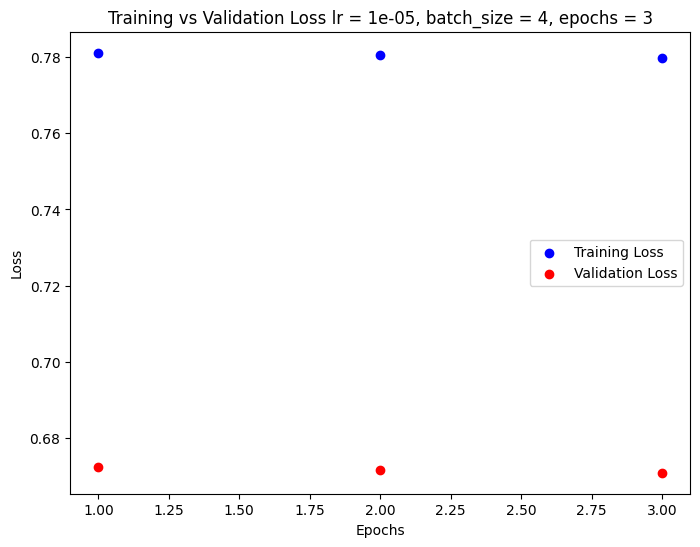

Hyperparameters: {'learning_rate': 1e-05, 'epochs': 5, 'batch_size': 4}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/5 - Train Loss: 1.2659, Val Loss: 1.2658
Epoch 2/5 - Train Loss: 1.2649, Val Loss: 1.2645
Epoch 3/5 - Train Loss: 1.2638, Val Loss: 1.2631
Epoch 4/5 - Train Loss: 1.2628, Val Loss: 1.2617
Epoch 5/5 - Train Loss: 1.2617, Val Loss: 1.2603


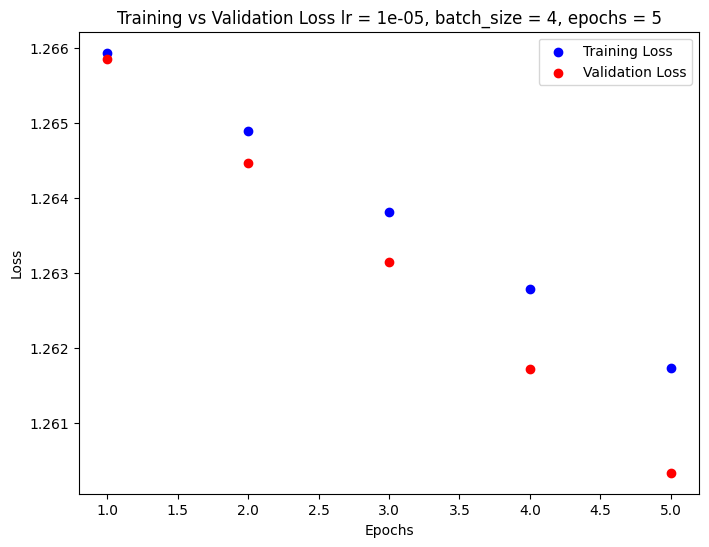

Hyperparameters: {'learning_rate': 0.001, 'epochs': 3, 'batch_size': 4}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/3 - Train Loss: 1.1220, Val Loss: 1.0052
Epoch 2/3 - Train Loss: 1.0244, Val Loss: 0.8873
Epoch 3/3 - Train Loss: 0.9351, Val Loss: 0.7917


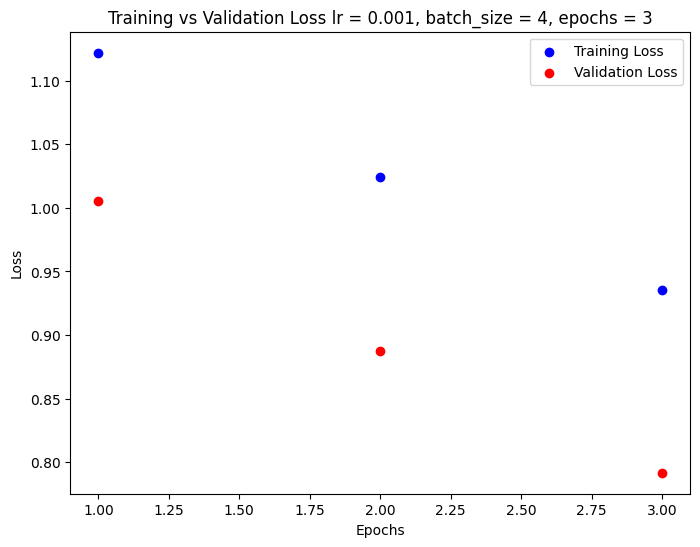

Hyperparameters: {'learning_rate': 1e-05, 'epochs': 1, 'batch_size': 4}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/1 - Train Loss: 0.9437, Val Loss: 0.9315


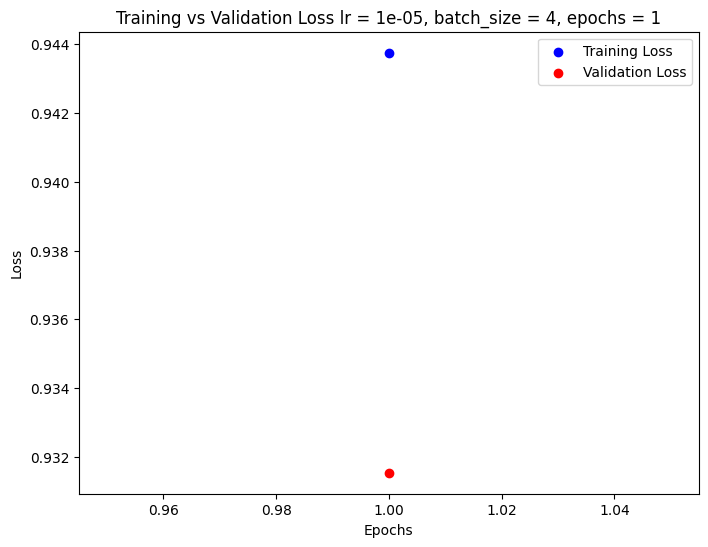

Hyperparameters: {'learning_rate': 0.001, 'epochs': 5, 'batch_size': 2}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/5 - Train Loss: 1.2616, Val Loss: 1.1778
Epoch 2/5 - Train Loss: 1.1047, Val Loss: 1.0126
Epoch 3/5 - Train Loss: 0.9856, Val Loss: 0.8836
Epoch 4/5 - Train Loss: 0.8907, Val Loss: 0.7732
Epoch 5/5 - Train Loss: 0.8034, Val Loss: 0.6614


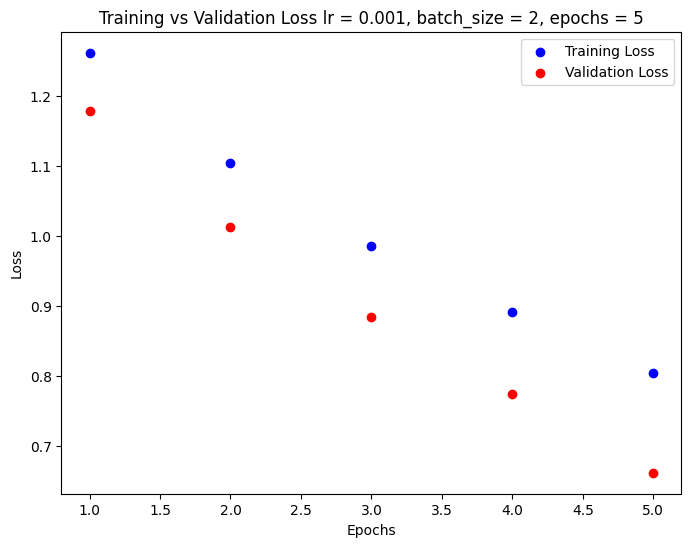

Hyperparameters: {'learning_rate': 0.001, 'epochs': 5, 'batch_size': 4}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/5 - Train Loss: 1.2470, Val Loss: 1.2979
Epoch 2/5 - Train Loss: 1.1459, Val Loss: 1.1706
Epoch 3/5 - Train Loss: 1.0581, Val Loss: 1.0638
Epoch 4/5 - Train Loss: 0.9848, Val Loss: 0.9617
Epoch 5/5 - Train Loss: 0.9132, Val Loss: 0.8762


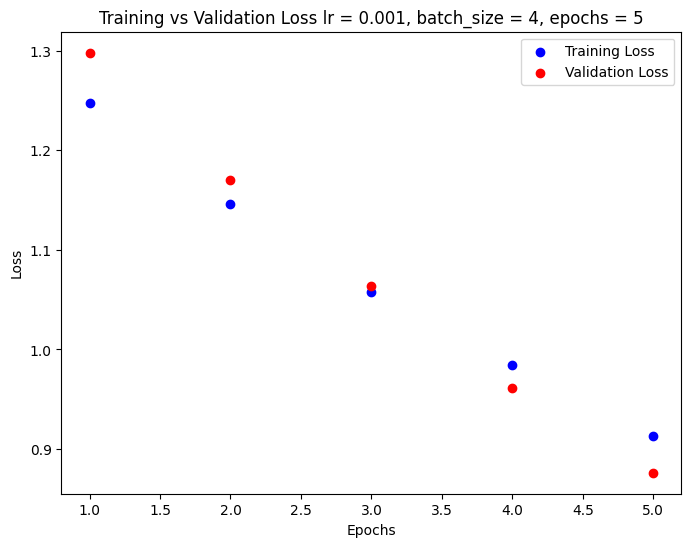

Stopping HPO due to exhausted search space: 12 of 12 possible configs ran.
Fitted model: CustomNeuralNetworkClassifier/T1 ...
	0.619	 = Validation score   (accuracy)
	2.89s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: CustomNeuralNetworkClassifier/T2 ...
	0.2381	 = Validation score   (accuracy)
	1.7s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: CustomNeuralNetworkClassifier/T3 ...
	0.2857	 = Validation score   (accuracy)
	7.83s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: CustomNeuralNetworkClassifier/T4 ...
	0.7619	 = Validation score   (accuracy)
	7.96s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: CustomNeuralNetworkClassifier/T5 ...
	0.4762	 = Validation score   (accuracy)
	1.49s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: CustomNeuralNetworkClassifier/T6 ...
	0.3333	 = Validation score   (accuracy)
	6.94s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: CustomNeuralN

In [145]:
random_searcher_instance = ag_searcher.LocalRandomSearcher(search_space=custom_hyperparameters[CustomNeuralNetworkClassifier])

random_search_tune_kwargs = {
    "scheduler": "local",
    "searcher": random_searcher_instance,
    "time_out": 200000
}

random_predictor = TabularPredictor(label='target', path='my_models/random_search', eval_metric='accuracy').fit(
    train_df,
    hyperparameters=custom_hyperparameters,
    hyperparameter_tune_kwargs=random_search_tune_kwargs,
    time_limit=200,
    raise_on_no_models_fitted=False
)

### Hyperband Schedular

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       9.12 GB / 12.67 GB (71.9%)
Disk Space Avail:   73.39 GB / 107.72 GB (68.1%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'         : Strong accuracy with fast inference spee

Hyperparameters: {'learning_rate': 0.001, 'epochs': 1, 'batch_size': 2}
Epoch 1/1 - Train Loss: 1.0682, Val Loss: 0.9681


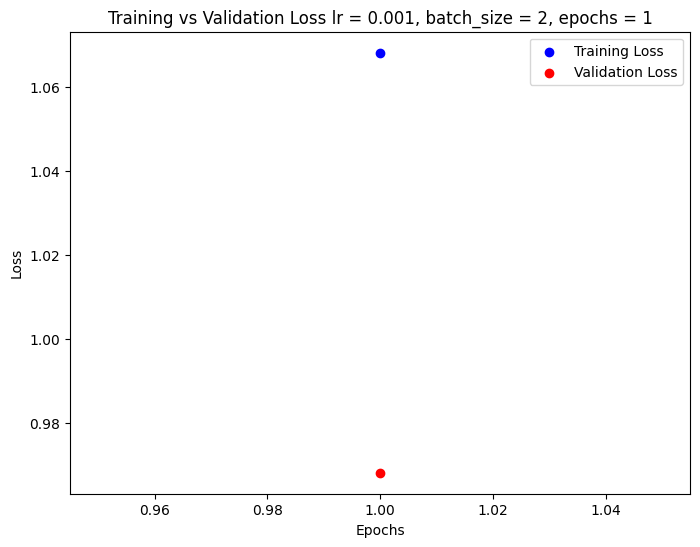

Hyperparameters: {'learning_rate': 0.001, 'epochs': 1, 'batch_size': 4}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/1 - Train Loss: 0.9856, Val Loss: 0.8823


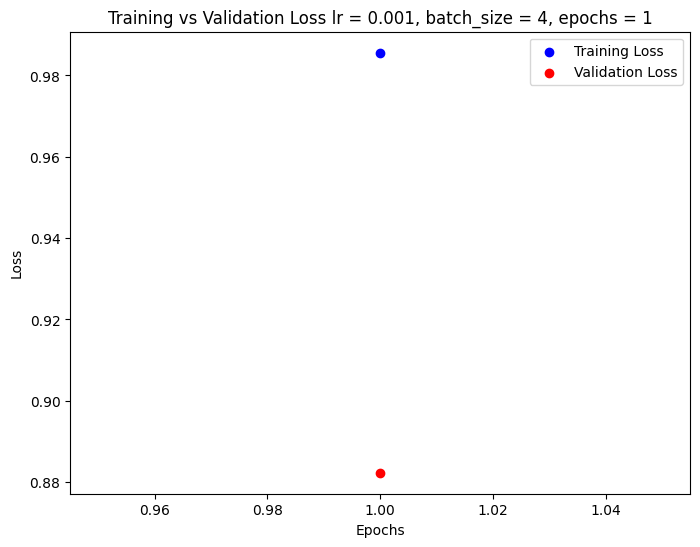

Hyperparameters: {'learning_rate': 1e-05, 'epochs': 5, 'batch_size': 2}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/5 - Train Loss: 0.9565, Val Loss: 0.9789
Epoch 2/5 - Train Loss: 0.9553, Val Loss: 0.9776
Epoch 3/5 - Train Loss: 0.9543, Val Loss: 0.9761
Epoch 4/5 - Train Loss: 0.9532, Val Loss: 0.9747
Epoch 5/5 - Train Loss: 0.9521, Val Loss: 0.9734


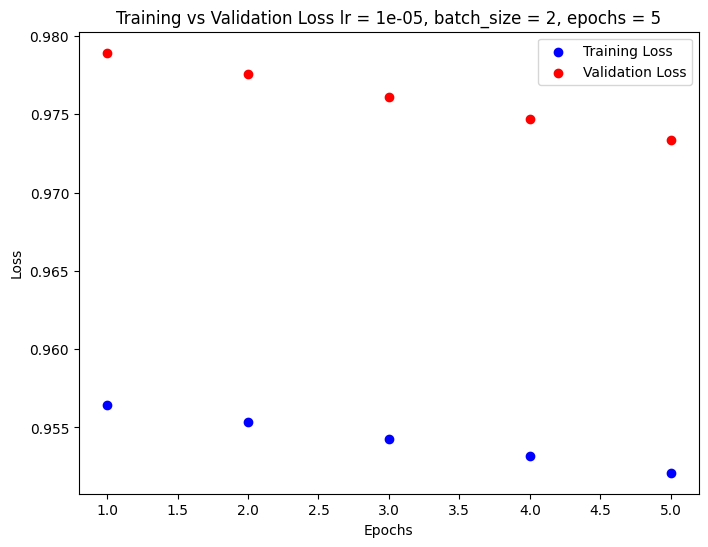

Hyperparameters: {'learning_rate': 0.001, 'epochs': 3, 'batch_size': 2}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/3 - Train Loss: 1.1153, Val Loss: 1.1301
Epoch 2/3 - Train Loss: 0.9726, Val Loss: 0.9466
Epoch 3/3 - Train Loss: 0.8523, Val Loss: 0.7923


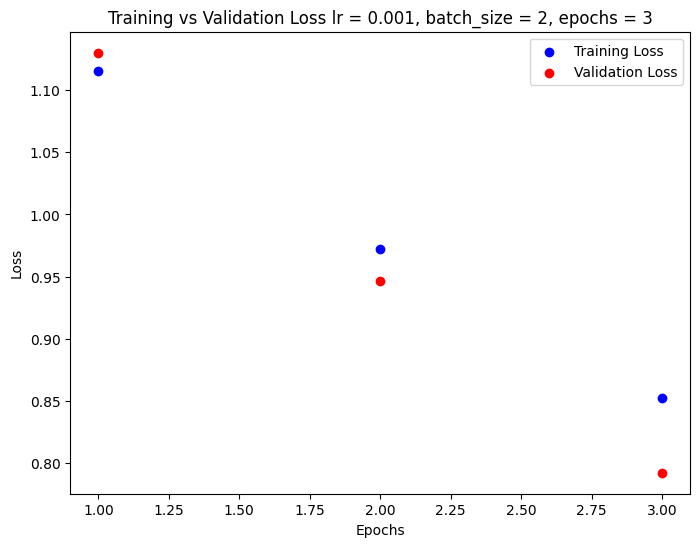

Hyperparameters: {'learning_rate': 1e-05, 'epochs': 1, 'batch_size': 2}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/1 - Train Loss: 1.1824, Val Loss: 1.2477


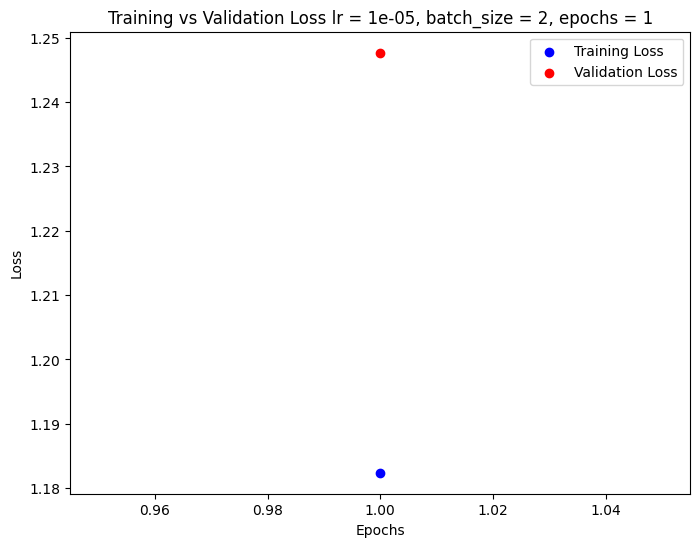

Hyperparameters: {'learning_rate': 1e-05, 'epochs': 3, 'batch_size': 2}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/3 - Train Loss: 1.0879, Val Loss: 1.0688
Epoch 2/3 - Train Loss: 1.0859, Val Loss: 1.0664
Epoch 3/3 - Train Loss: 1.0840, Val Loss: 1.0638


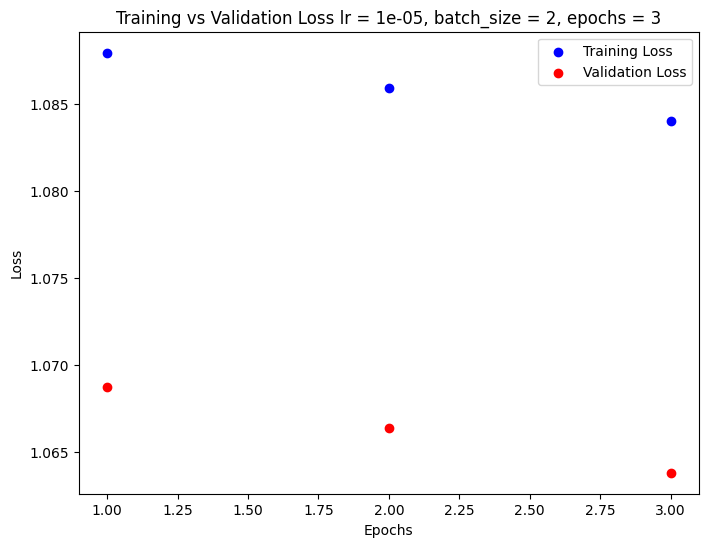

Hyperparameters: {'learning_rate': 1e-05, 'epochs': 3, 'batch_size': 4}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/3 - Train Loss: 0.9146, Val Loss: 0.8481
Epoch 2/3 - Train Loss: 0.9139, Val Loss: 0.8473
Epoch 3/3 - Train Loss: 0.9131, Val Loss: 0.8465


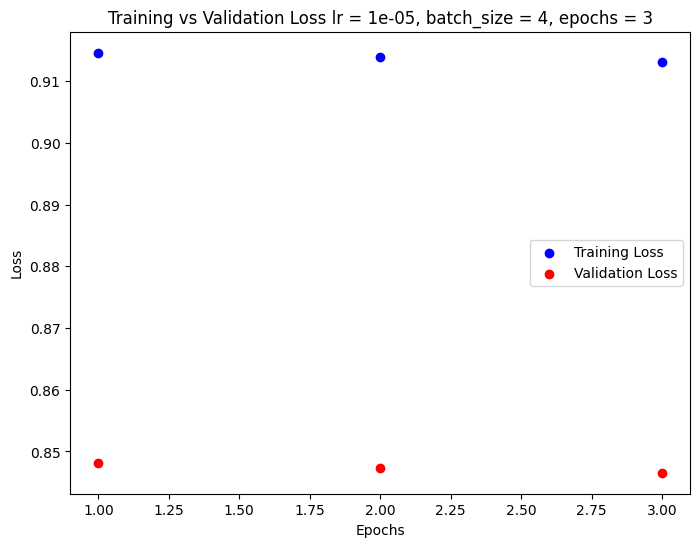

Hyperparameters: {'learning_rate': 1e-05, 'epochs': 5, 'batch_size': 4}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/5 - Train Loss: 1.5173, Val Loss: 1.8821
Epoch 2/5 - Train Loss: 1.5156, Val Loss: 1.8797
Epoch 3/5 - Train Loss: 1.5141, Val Loss: 1.8772
Epoch 4/5 - Train Loss: 1.5124, Val Loss: 1.8749
Epoch 5/5 - Train Loss: 1.5108, Val Loss: 1.8724


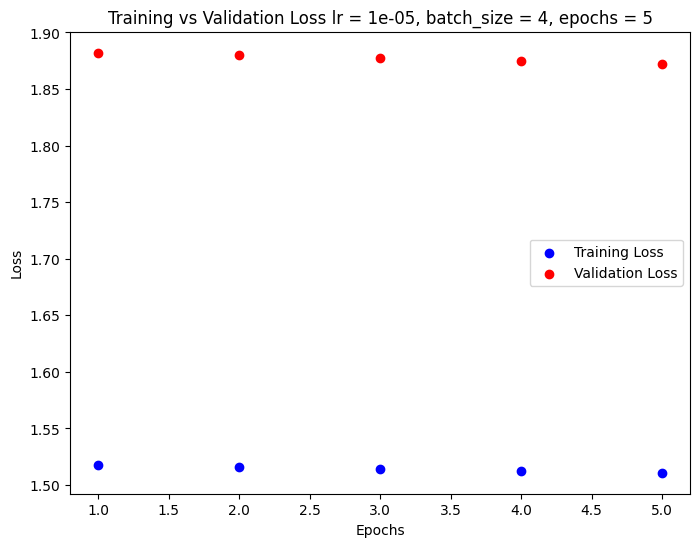

Hyperparameters: {'learning_rate': 0.001, 'epochs': 3, 'batch_size': 4}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/3 - Train Loss: 1.1187, Val Loss: 0.9998
Epoch 2/3 - Train Loss: 1.0143, Val Loss: 0.8749
Epoch 3/3 - Train Loss: 0.9312, Val Loss: 0.7794


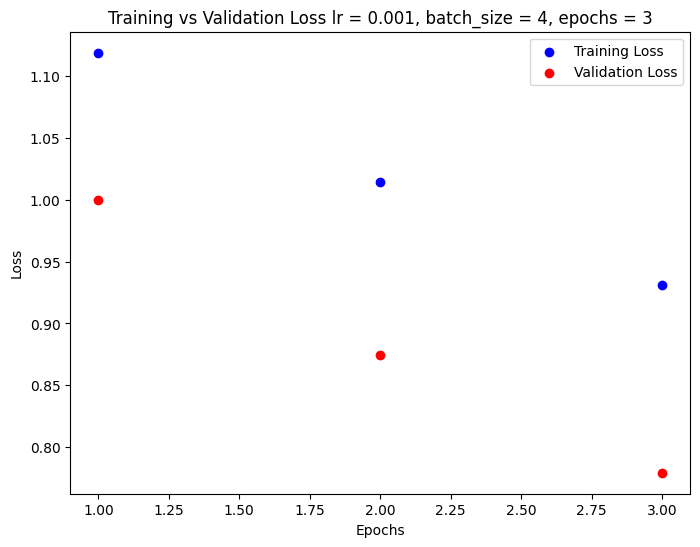

Hyperparameters: {'learning_rate': 1e-05, 'epochs': 1, 'batch_size': 4}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/1 - Train Loss: 1.4600, Val Loss: 1.1959


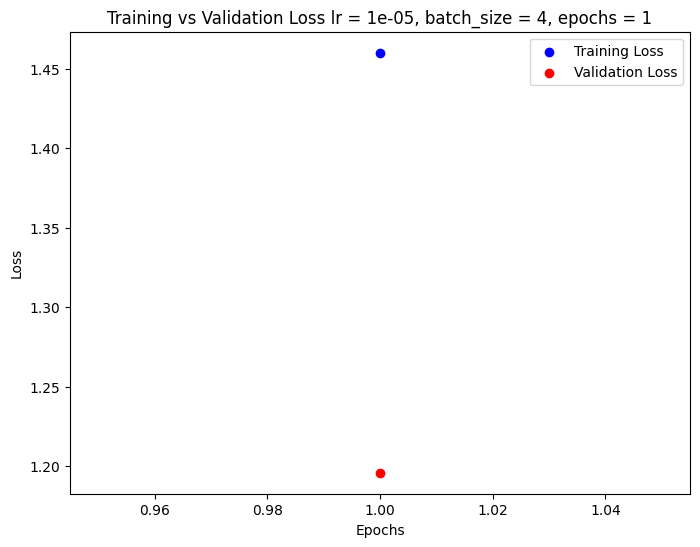

Hyperparameters: {'learning_rate': 0.001, 'epochs': 5, 'batch_size': 2}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/5 - Train Loss: 1.1700, Val Loss: 1.0736
Epoch 2/5 - Train Loss: 0.9823, Val Loss: 0.8359
Epoch 3/5 - Train Loss: 0.8434, Val Loss: 0.6607
Epoch 4/5 - Train Loss: 0.7437, Val Loss: 0.5441
Epoch 5/5 - Train Loss: 0.6723, Val Loss: 0.4661


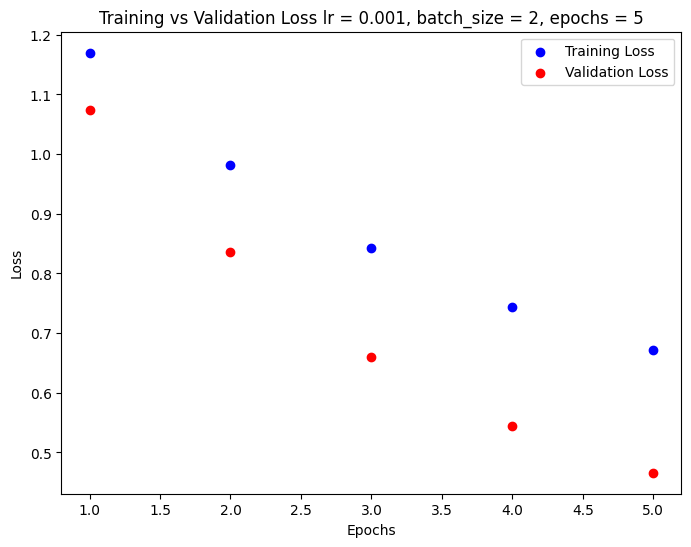

Hyperparameters: {'learning_rate': 0.001, 'epochs': 5, 'batch_size': 4}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/5 - Train Loss: 0.8440, Val Loss: 0.7030
Epoch 2/5 - Train Loss: 0.7540, Val Loss: 0.6110
Epoch 3/5 - Train Loss: 0.6814, Val Loss: 0.5353
Epoch 4/5 - Train Loss: 0.6216, Val Loss: 0.4803
Epoch 5/5 - Train Loss: 0.5733, Val Loss: 0.4349


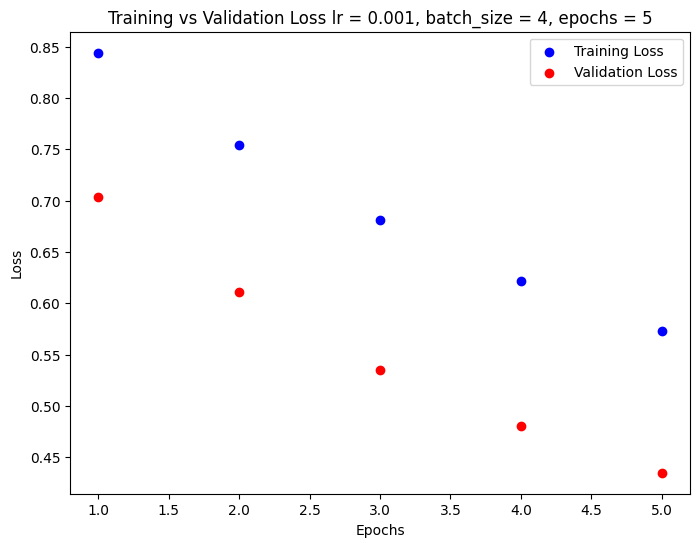

Stopping HPO due to exhausted search space: 12 of 12 possible configs ran.
Fitted model: CustomNeuralNetworkClassifier/T1 ...
	0.5714	 = Validation score   (accuracy)
	3.3s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: CustomNeuralNetworkClassifier/T2 ...
	0.4762	 = Validation score   (accuracy)
	1.14s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: CustomNeuralNetworkClassifier/T3 ...
	0.4762	 = Validation score   (accuracy)
	12.15s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: CustomNeuralNetworkClassifier/T4 ...
	0.7143	 = Validation score   (accuracy)
	6.67s	 = Training   runtime
	0.02s	 = Validation runtime
Fitted model: CustomNeuralNetworkClassifier/T5 ...
	0.0952	 = Validation score   (accuracy)
	1.59s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: CustomNeuralNetworkClassifier/T6 ...
	0.4286	 = Validation score   (accuracy)
	7.56s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: CustomNeura

In [146]:
hyperband_search_tune_kwargs = {
    "scheduler": "local",
    "searcher": random_searcher_instance,
    "search_strategy": "hyperband",
    "time_out": 200000
}

hyperband_predictor = TabularPredictor(label='target', path='my_models/hyperband', eval_metric='accuracy').fit(
    train_df,
    hyperparameters=custom_hyperparameters,
    hyperparameter_tune_kwargs=hyperband_search_tune_kwargs,
    time_limit=200,
    raise_on_no_models_fitted=False
)

### Bayesian Search

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       9.07 GB / 12.67 GB (71.5%)
Disk Space Avail:   73.39 GB / 107.72 GB (68.1%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'         : Strong accuracy with fast inference spee

Hyperparameters: {'learning_rate': 0.001, 'epochs': 1, 'batch_size': 2}
Epoch 1/1 - Train Loss: 1.0134, Val Loss: 0.6967


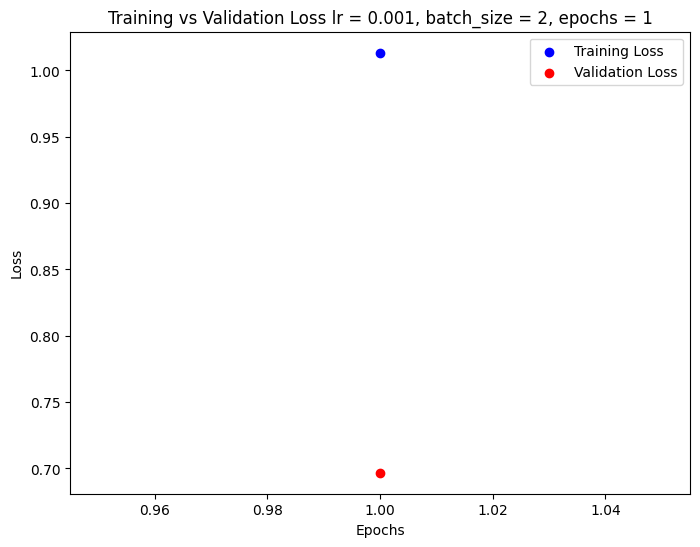

Hyperparameters: {'learning_rate': 0.001, 'epochs': 1, 'batch_size': 4}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/1 - Train Loss: 1.1434, Val Loss: 1.1159


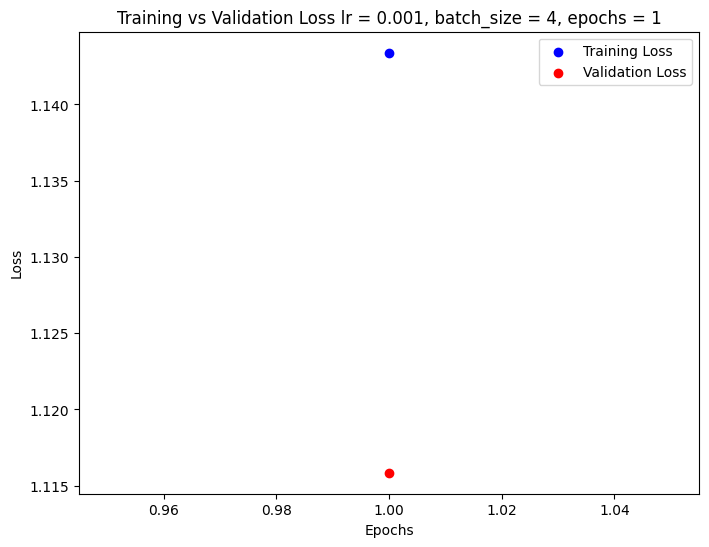

Hyperparameters: {'learning_rate': 1e-05, 'epochs': 5, 'batch_size': 2}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/5 - Train Loss: 1.3174, Val Loss: 1.2978
Epoch 2/5 - Train Loss: 1.3151, Val Loss: 1.2945
Epoch 3/5 - Train Loss: 1.3128, Val Loss: 1.2914
Epoch 4/5 - Train Loss: 1.3104, Val Loss: 1.2882
Epoch 5/5 - Train Loss: 1.3082, Val Loss: 1.2851


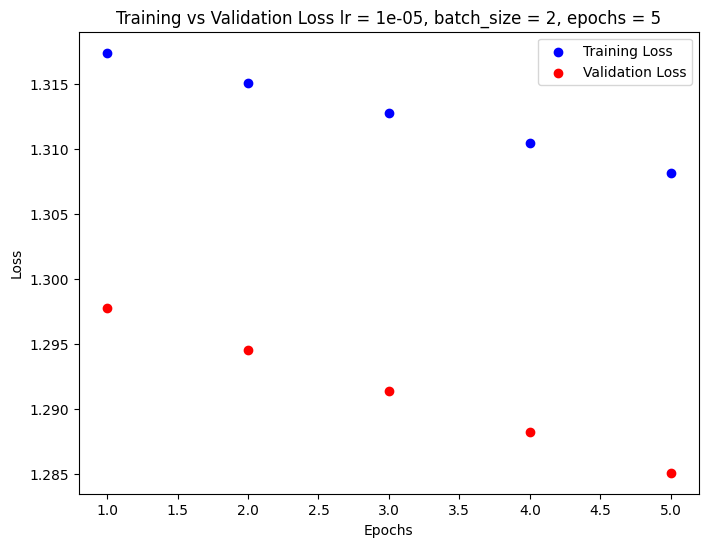

Hyperparameters: {'learning_rate': 0.001, 'epochs': 3, 'batch_size': 2}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/3 - Train Loss: 1.2620, Val Loss: 1.0689
Epoch 2/3 - Train Loss: 1.0546, Val Loss: 0.8428
Epoch 3/3 - Train Loss: 0.8942, Val Loss: 0.6575


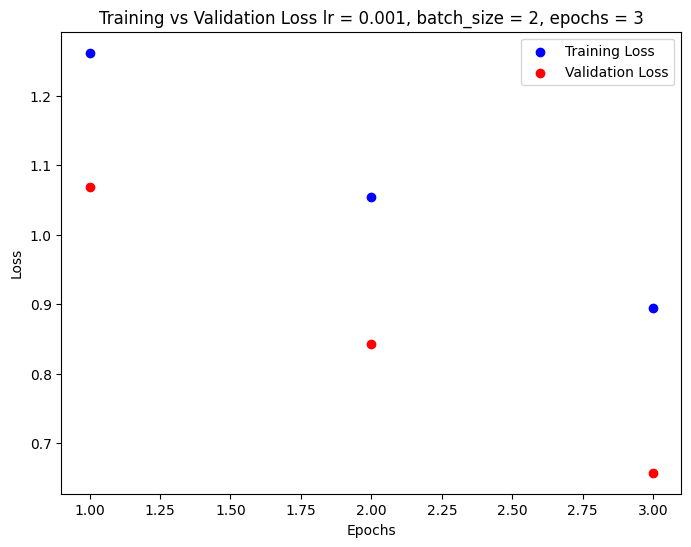

Hyperparameters: {'learning_rate': 1e-05, 'epochs': 1, 'batch_size': 2}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/1 - Train Loss: 1.2402, Val Loss: 1.4606


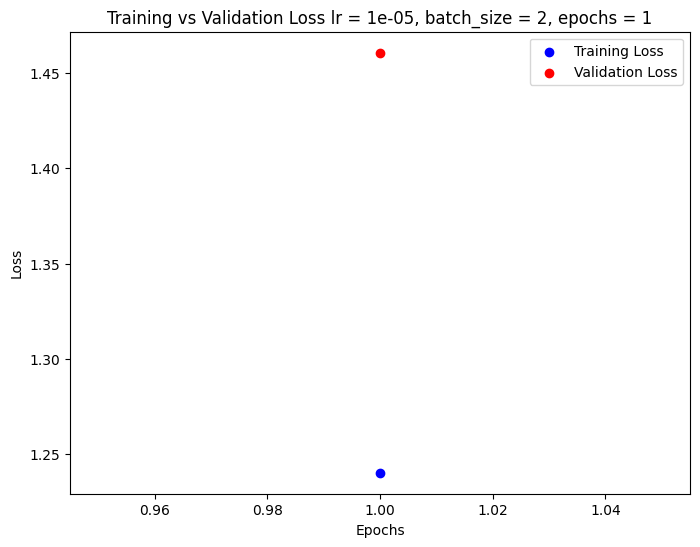

Hyperparameters: {'learning_rate': 1e-05, 'epochs': 3, 'batch_size': 2}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/3 - Train Loss: 0.9426, Val Loss: 0.7839
Epoch 2/3 - Train Loss: 0.9406, Val Loss: 0.7815
Epoch 3/3 - Train Loss: 0.9387, Val Loss: 0.7789


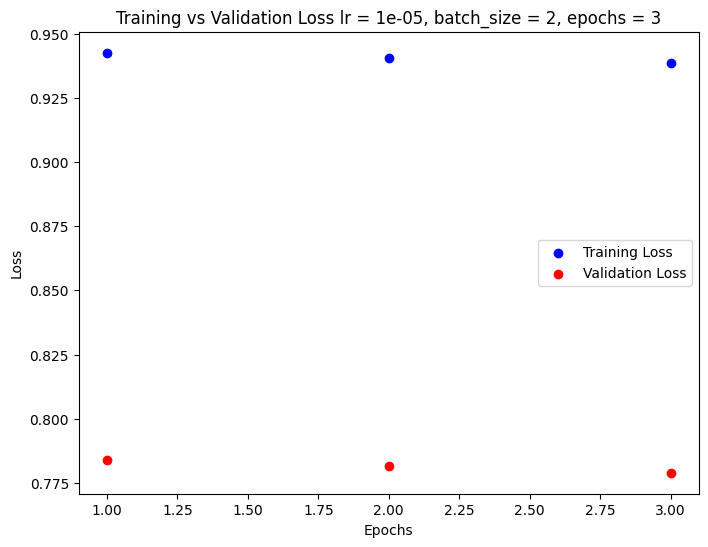

Hyperparameters: {'learning_rate': 1e-05, 'epochs': 3, 'batch_size': 4}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/3 - Train Loss: 0.8938, Val Loss: 0.7800
Epoch 2/3 - Train Loss: 0.8929, Val Loss: 0.7789
Epoch 3/3 - Train Loss: 0.8921, Val Loss: 0.7776


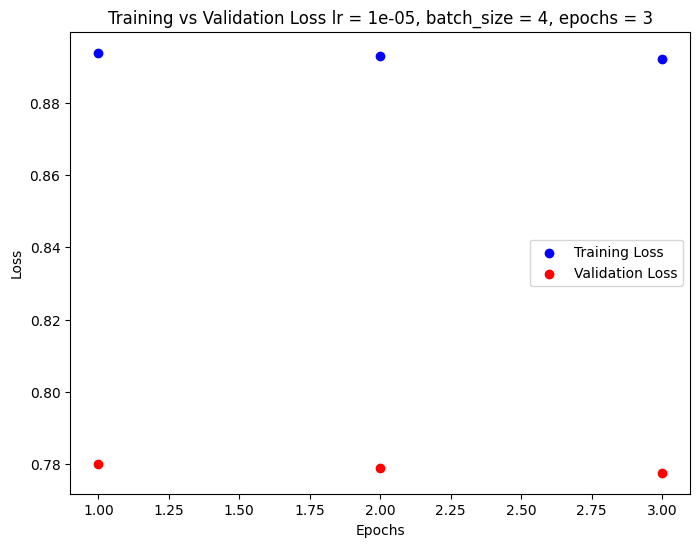

Hyperparameters: {'learning_rate': 1e-05, 'epochs': 5, 'batch_size': 4}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/5 - Train Loss: 1.0789, Val Loss: 1.1077
Epoch 2/5 - Train Loss: 1.0776, Val Loss: 1.1057
Epoch 3/5 - Train Loss: 1.0762, Val Loss: 1.1039
Epoch 4/5 - Train Loss: 1.0750, Val Loss: 1.1018
Epoch 5/5 - Train Loss: 1.0736, Val Loss: 1.0999


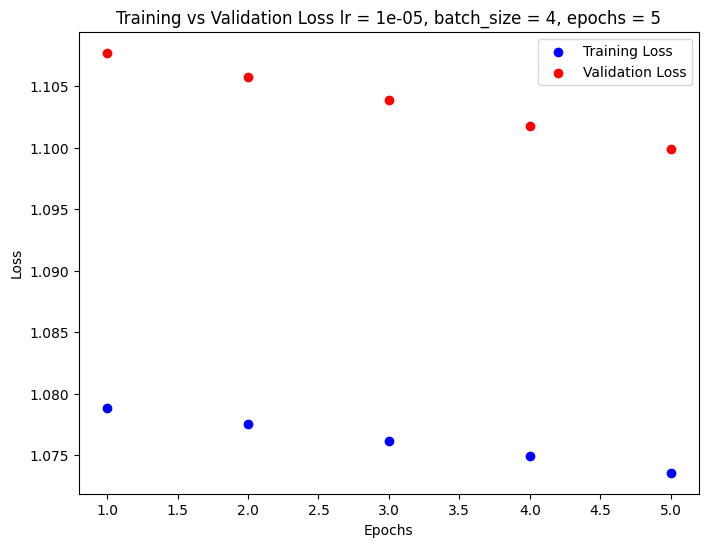

Hyperparameters: {'learning_rate': 0.001, 'epochs': 3, 'batch_size': 4}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/3 - Train Loss: 1.0148, Val Loss: 0.7382
Epoch 2/3 - Train Loss: 0.9214, Val Loss: 0.6472
Epoch 3/3 - Train Loss: 0.8465, Val Loss: 0.5697


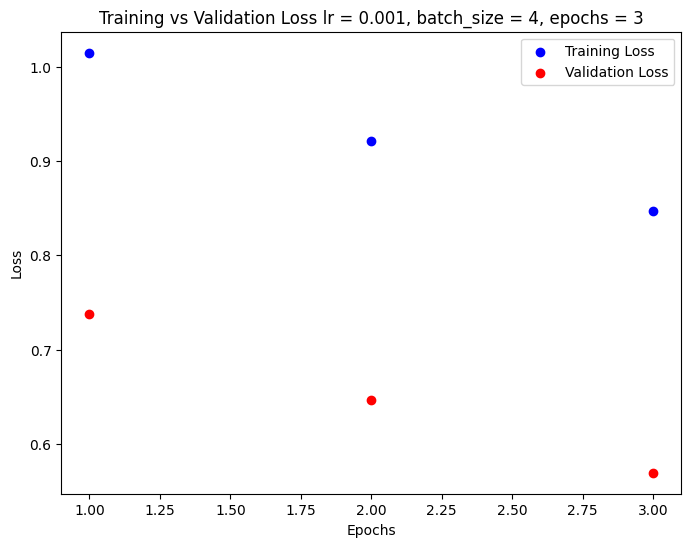

Hyperparameters: {'learning_rate': 1e-05, 'epochs': 1, 'batch_size': 4}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/1 - Train Loss: 1.3444, Val Loss: 1.4812


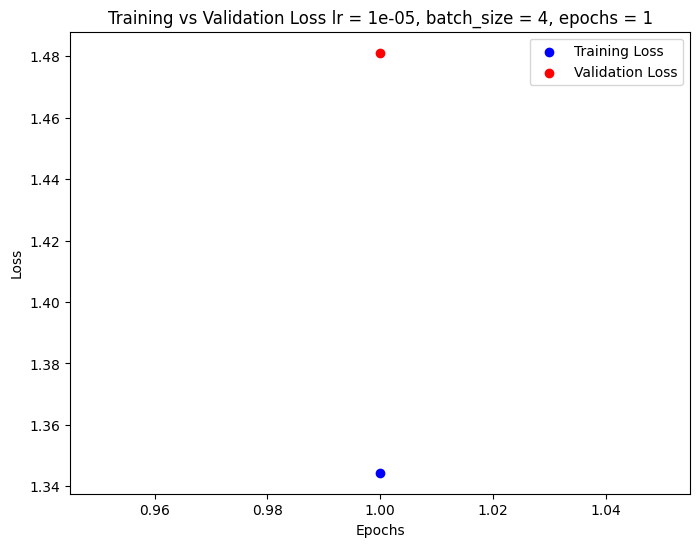

Hyperparameters: {'learning_rate': 0.001, 'epochs': 5, 'batch_size': 2}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/5 - Train Loss: 1.6856, Val Loss: 1.6947
Epoch 2/5 - Train Loss: 1.4410, Val Loss: 1.3853
Epoch 3/5 - Train Loss: 1.2460, Val Loss: 1.1289
Epoch 4/5 - Train Loss: 1.0818, Val Loss: 0.9354
Epoch 5/5 - Train Loss: 0.9470, Val Loss: 0.7798


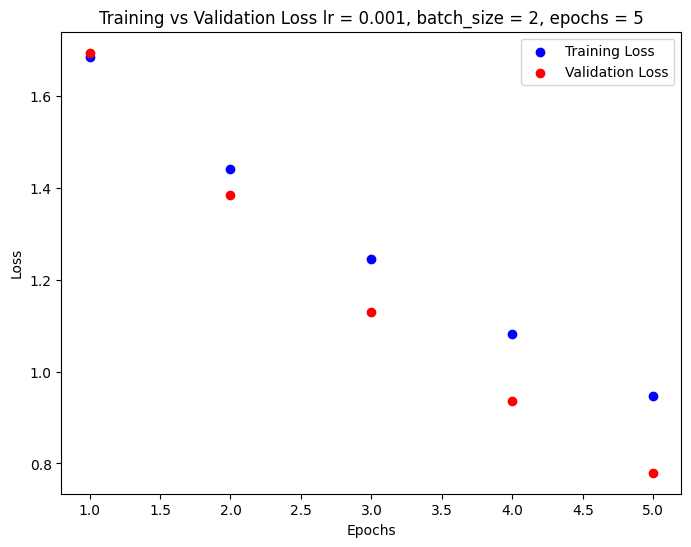

Hyperparameters: {'learning_rate': 0.001, 'epochs': 5, 'batch_size': 4}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/5 - Train Loss: 0.8401, Val Loss: 0.6123
Epoch 2/5 - Train Loss: 0.7672, Val Loss: 0.5463
Epoch 3/5 - Train Loss: 0.7033, Val Loss: 0.4890
Epoch 4/5 - Train Loss: 0.6462, Val Loss: 0.4366
Epoch 5/5 - Train Loss: 0.5946, Val Loss: 0.3955


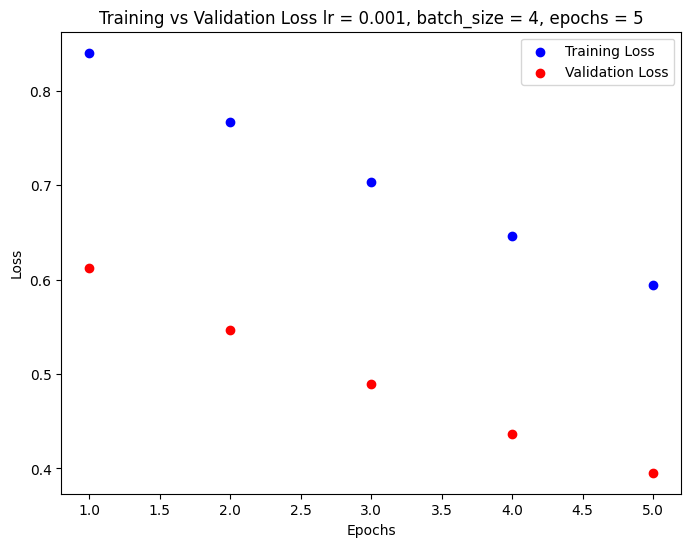

Stopping HPO due to exhausted search space: 12 of 12 possible configs ran.
Fitted model: CustomNeuralNetworkClassifier/T1 ...
	0.381	 = Validation score   (accuracy)
	1.71s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: CustomNeuralNetworkClassifier/T2 ...
	0.3333	 = Validation score   (accuracy)
	0.9s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: CustomNeuralNetworkClassifier/T3 ...
	0.0476	 = Validation score   (accuracy)
	14.12s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: CustomNeuralNetworkClassifier/T4 ...
	0.381	 = Validation score   (accuracy)
	6.98s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: CustomNeuralNetworkClassifier/T5 ...
	0.2857	 = Validation score   (accuracy)
	2.98s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: CustomNeuralNetworkClassifier/T6 ...
	0.6667	 = Validation score   (accuracy)
	3.6s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: CustomNeuralNe

In [147]:
bayesian_search_tune_kwargs = {
    "scheduler": "local",
    "searcher": random_searcher_instance,
    "search_strategy": "bayesopt",
    "time_out": 200000
}

bayesian_predictor = TabularPredictor(label='target', path='my_models/bayesian', eval_metric='accuracy').fit(
    train_df,
    hyperparameters=custom_hyperparameters,
    hyperparameter_tune_kwargs=bayesian_search_tune_kwargs,
    time_limit=200,
    raise_on_no_models_fitted=False
)

### Comparing the 4 strategies

#### Helper to get params from model name

In [131]:
name_to_hyperparams = {
    "grid_search": {
        "CustomNeuralNetworkClassifier/T1": [1e-3, 1, 2],
        "CustomNeuralNetworkClassifier/T2": [1e-5, 1, 2],
        "CustomNeuralNetworkClassifier/T3": [1e-3, 3, 2],
        "CustomNeuralNetworkClassifier/T4": [1e-5, 3, 2],
        "CustomNeuralNetworkClassifier/T5": [1e-3, 5, 2],
        "CustomNeuralNetworkClassifier/T6": [1e-5, 5, 2],
        "CustomNeuralNetworkClassifier/T7": [1e-3, 1, 4],
        "CustomNeuralNetworkClassifier/T8": [1e-5, 1, 4],
        "CustomNeuralNetworkClassifier/T9": [1e-3, 3, 4],
        "CustomNeuralNetworkClassifier/T10": [1e-5, 3, 4],
        "CustomNeuralNetworkClassifier/T11": [1e-3, 5, 4],
        "CustomNeuralNetworkClassifier/T12": [1e-5, 5, 4]
    }, "random_search": {
            "CustomNeuralNetworkClassifier/T1" : [1e-3, 1, 2],
            "CustomNeuralNetworkClassifier/T2" : [1e-3, 1, 2],
            "CustomNeuralNetworkClassifier/T3" : [1e-5, 5, 2],
            "CustomNeuralNetworkClassifier/T4" : [1e-3, 3, 2],
            "CustomNeuralNetworkClassifier/T5" : [1e-5, 1, 2],
            "CustomNeuralNetworkClassifier/T6" : [1e-5, 3, 2],
            "CustomNeuralNetworkClassifier/T7" : [1e-5, 3, 4],
            "CustomNeuralNetworkClassifier/T8" : [1e-5, 5, 4],
            "CustomNeuralNetworkClassifier/T9" : [1e-3, 3, 4],
            "CustomNeuralNetworkClassifier/T10" :[1e-5, 1, 4],
            "CustomNeuralNetworkClassifier/T11" :[1e-3, 5, 2],
            "CustomNeuralNetworkClassifier/T12" :[1e-3, 5, 4]
    }, "hyperband_search": {
            "CustomNeuralNetworkClassifier/T1": [1e-3, 1, 2],
            "CustomNeuralNetworkClassifier/T2": [1e-3, 1, 4],
            "CustomNeuralNetworkClassifier/T3": [1e-5, 5, 2],
            "CustomNeuralNetworkClassifier/T4": [1e-3, 3, 2],
            "CustomNeuralNetworkClassifier/T5": [1e-5, 1, 2],
            "CustomNeuralNetworkClassifier/T6": [1e-5, 3, 2],
            "CustomNeuralNetworkClassifier/T7": [1e-5, 3, 4],
            "CustomNeuralNetworkClassifier/T8": [1e-5, 5, 4],
            "CustomNeuralNetworkClassifier/T9": [1e-3, 3, 4],
            "CustomNeuralNetworkClassifier/T10": [1e-5, 1, 4],
            "CustomNeuralNetworkClassifier/T11": [1e-3, 5, 2],
            "CustomNeuralNetworkClassifier/T12": [1e-3, 5, 4]
    }, "bayesian_search": {
            "CustomNeuralNetworkClassifier/T1": [1e-3, 1, 2],
            "CustomNeuralNetworkClassifier/T2": [1e-3, 1, 4],
            "CustomNeuralNetworkClassifier/T3": [1e-5, 5, 2],
            "CustomNeuralNetworkClassifier/T4": [1e-3, 3, 2],
            "CustomNeuralNetworkClassifier/T5": [1e-5, 1, 2],
            "CustomNeuralNetworkClassifier/T6": [1e-5, 3, 2],
            "CustomNeuralNetworkClassifier/T7": [1e-5, 3, 4],
            "CustomNeuralNetworkClassifier/T8": [1e-5, 5, 4],
            "CustomNeuralNetworkClassifier/T9": [1e-3, 3, 4],
            "CustomNeuralNetworkClassifier/T10": [1e-5, 1, 4],
            "CustomNeuralNetworkClassifier/T11": [1e-3, 5, 2],
            "CustomNeuralNetworkClassifier/T12": [1e-3, 5, 4]
    }
}

Delete the WeightedEnsemble_L2 model (which is trained by default)

In [148]:
grid_predictor.delete_models(models_to_delete='WeightedEnsemble_L2', dry_run=False)
random_predictor.delete_models(models_to_delete='WeightedEnsemble_L2', dry_run=False)
hyperband_predictor.delete_models(models_to_delete='WeightedEnsemble_L2', dry_run=False)
bayesian_predictor.delete_models(models_to_delete='WeightedEnsemble_L2', dry_run=False)

Deleting model WeightedEnsemble_L2. All files under /content/my_models/grid_search/models/WeightedEnsemble_L2 will be removed.
Deleting model WeightedEnsemble_L2. All files under /content/my_models/random_search/models/WeightedEnsemble_L2 will be removed.
Deleting model WeightedEnsemble_L2. All files under /content/my_models/hyperband/models/WeightedEnsemble_L2 will be removed.
Deleting model WeightedEnsemble_L2. All files under /content/my_models/bayesian/models/WeightedEnsemble_L2 will be removed.


#### Store the results of all models in a dataframe

In [133]:
df_data = []
search_strategies = {"grid_search":grid_predictor, "random_search":random_predictor, "hyperband_search":hyperband_predictor, "bayesian_search":bayesian_predictor}
for search_strategy in list(search_strategies.keys()):
    predictor = search_strategies[search_strategy]
    for model in predictor.model_names():
        hparams = name_to_hyperparams[search_strategy].get(model, ["na", "na", "na"])
        predictions = predictor.predict(test_df, model=model)
        true_labels = test_df['target']
        acc = accuracy_score(true_labels, predictions)
        f1 = f1_score(true_labels, predictions, average='weighted')
        df_data.append({'model_name': model, 'lr': hparams[0], 'epochs': hparams[1], 'batch_size': hparams[2], 'strategy': search_strategy, 'accuracy': acc, 'f1-score': f1})


In [138]:
df = pd.DataFrame(df_data)
df = df.sort_values(by=['strategy', 'accuracy'], ascending=[True, False])
df

,model_name,lr,epochs,batch_size,strategy,accuracy,f1-score
46,CustomNeuralNetworkClassifier/T11,0.001,5,2,bayesian_search,0.900000,0.899233
47,CustomNeuralNetworkClassifier/T12,0.001,5,4,bayesian_search,0.800000,0.766226
48,WeightedEnsemble_L2,na,na,na,bayesian_search,0.800000,0.766226
36,CustomNeuralNetworkClassifier/T1,0.001,1,2,bayesian_search,0.700000,0.690145
41,CustomNeuralNetworkClassifier/T6,0.00001,3,2,bayesian_search,0.666667,0.568889
37,CustomNeuralNetworkClassifier/T2,0.001,1,4,bayesian_search,0.566667,0.451394
44,CustomNeuralNetworkClassifier/T9,0.001,3,4,bayesian_search,0.533333,0.499252
40,CustomNeuralNetworkClassifier/T5,0.00001,1,2,bayesian_search,0.466667,0.373810
39,CustomNeuralNetworkClassifier/T4,0.001,3,2,bayesian_search,0.433333,0.363194
38,CustomNeuralNetworkClassifier/T3,0.00001,5,2,bayesian_search,0.366667,0.311111


### Relation between hyperparameters and and their impact on performance
1. `lr` for small values is directly proportional to the performance i.e. higher the `lr`, higher the performance as for very high values, the the model start diverging from the minima and the gradients overshoot. <br>
2. `epochs` is directly proportional to the performance i.e. higher the `epochs`, higher the performance as the model is seeing the data for more number of times. <br>
3. `batch_size` is inversely proportional to the performace i.e. higher the `batch_size`, higher the performance

### Mannual Tuning vs Automated Search
Which approach is better and why?
---
- Mannual Tuning allows to tune hyperparameters based on prior knowledge and intiution. While Automated Search explores all possible hyperparameters and provides the best of them.
- So, for a person who is expert in tuning hyperparameters, mannual tuning is preferable as it would be quicker as he/she knows in which direction he/she should go.
- Moreover, it also depends on the amount of compute available as automatic search requires a lot of compute.